# PC LAB 4 - Group 4 - Sofia Michael Yash Omar

Time spent: 15-20 hours

Difficulty: 7/10

## Import Libraries and Download the Data

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from chronos import ChronosPipeline
import torch
import pickle
import plotly.io as pio
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge
import warnings
warnings.filterwarnings('ignore')

In [2]:
prices = pd.read_csv('Data_PCLab4_Stock_Price.csv')
volumes = pd.read_csv('Data_PCLab4_Stock_Volume.csv')
interest_rates = pd.read_csv('interest_rates.csv')
oil_prices = pd.read_csv('oil_prices.csv')

In [3]:
prices.head()

Date       AAPL         BA          T    MGM        AMZN         IBM  \
0  2012-01-12  60.198570  75.510002  30.120001  12.13  175.929993  180.550003   
1  2012-01-13  59.972858  74.599998  30.070000  12.35  178.419998  179.160004   
2  2012-01-17  60.671429  75.239998  30.250000  12.25  181.660004  180.000000   
3  2012-01-18  61.301430  75.059998  30.330000  12.73  189.440002  181.070007   
4  2012-01-19  61.107143  75.559998  30.420000  12.80  194.449997  180.520004   

        TSLA        GOOG        sp500  
0  28.250000  313.644379  1295.500000  
1  22.790001  311.328064  1289.089966  
2  26.600000  313.116364  1293.670044  
3  26.809999  315.273285  1308.040039  
4  26.760000  318.590851  1314.500000

In [4]:
interest_rates

observation_date  FEDFUNDS
0         2012-01-01      0.08
1         2012-02-01      0.10
2         2012-03-01      0.13
3         2012-04-01      0.14
4         2012-05-01      0.16
..               ...       ...
160       2025-05-01      4.33
161       2025-06-01      4.33
162       2025-07-01      4.33
163       2025-08-01      4.33
164       2025-09-01      4.22

[165 rows x 2 columns]

In [5]:
interest_rates.rename(columns={'observation_date' : 'Date', 'FEDFUNDS' : 'Interest_Rates'}, inplace=True)

In [6]:
oil_prices

observation_date  DCOILWTICO
0          2012-01-03      102.96
1          2012-01-04      103.22
2          2012-01-05      101.81
3          2012-01-06      101.56
4          2012-01-09      101.31
...               ...         ...
3580       2025-09-23       63.76
3581       2025-09-24       65.40
3582       2025-09-25       65.51
3583       2025-09-26       66.50
3584       2025-09-29       64.27

[3585 rows x 2 columns]

In [7]:
oil_prices.rename(columns={'observation_date' : 'Date', 'DCOILWTICO' : 'Oil_Prices'}, inplace=True)

In [8]:
tickers = prices.columns[1:].tolist()
tickers

['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG', 'sp500']

In [9]:
tickers = [ticker.replace('sp500', '^GSPC') for ticker in tickers]

In [10]:
start = '2012-01-12'
end = '2025-09-30'

In [11]:
data = yf.download(tickers, start=start, end=end)

df = data.stack().reset_index()
df.columns = ['Date', 'Ticker'] + [col for col in df.columns[2:]]
df.head()

[*********************100%***********************]  9 of 9 completed


Date Ticker       Close        High         Low        Open     Volume
0 2012-01-12   AAPL   12.650178   12.695508   12.570925   12.676896  212587200
1 2012-01-12   AMZN    8.796500    8.974500    8.787500    8.971000  107716000
2 2012-01-12     BA   61.786659   61.933946   61.189328   61.213875    3934500
3 2012-01-12   GOOG   15.575630   15.656028   15.497955   15.614716   75289148
4 2012-01-12    IBM  103.529694  104.309541  102.285388  104.280868    7197526

In [12]:
df.isna().sum()

Date      0
Ticker    0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [13]:
df = df.sort_values(by=['Ticker', 'Date'])
df['Return_5d'] = df.groupby('Ticker')['Close'].pct_change(periods=5).shift(-5)
df['Return_20d'] = df.groupby('Ticker')['Close'].pct_change(periods=20).shift(-20)
df['Return_60d'] = df.groupby('Ticker')['Close'].pct_change(periods=60).shift(-60)
df['MA_5d'] = df.groupby('Ticker')['Close'].rolling(window=5).mean().reset_index(0, drop=True)
df['MA_20d'] = df.groupby('Ticker')['Close'].rolling(window=20).mean().reset_index(0, drop=True)
df['MA_60d'] = df.groupby('Ticker')['Close'].rolling(window=60).mean().reset_index(0, drop=True)
df.dropna(inplace=True)
df

Date Ticker        Close         High          Low         Open  \
531   2012-04-09   AAPL    19.099699    19.208072    18.771580    18.796496   
540   2012-04-10   AAPL    18.865839    19.332951    18.792590    19.210770   
549   2012-04-11   AAPL    18.798597    19.118912    18.712739    19.098799   
558   2012-04-12   AAPL    18.695629    18.952602    18.627483    18.762574   
567   2012-04-13   AAPL    18.169081    18.753574    18.117447    18.735861   
...          ...    ...          ...          ...          ...          ...   
30455 2025-06-27  ^GSPC  6173.069824  6187.680176  6132.350098  6150.700195   
30464 2025-06-30  ^GSPC  6204.950195  6215.080078  6174.970215  6193.359863   
30473 2025-07-01  ^GSPC  6198.009766  6210.779785  6177.970215  6187.250000   
30482 2025-07-02  ^GSPC  6227.419922  6227.600098  6188.290039  6193.879883   
30491 2025-07-03  ^GSPC  6279.350098  6284.649902  6246.459961  6246.459961   

           Volume  Return_5d  Return_20d  Return_60d        MA_5d  \
531     597536800  -0.088175   -0.104915   -0.057872    18.865662   
540     889725200  -0.029820   -0.095888   -0.029438    18.924561   
549     696614800  -0.028521   -0.091057   -0.032450    18.905828   
558     614336800  -0.056731   -0.083899   -0.014259    18.896582   
567     859644800  -0.053286   -0.063646    0.004923    18.725769   
...           ...        ...         ...         ...          ...   
30455  7889350000   0.009219    0.035104    0.078381  6104.720020   
30464  5782900000   0.003315    0.026738    0.069786  6140.676074   
30473  6275310000   0.010528    0.026604    0.065620  6161.841992   
30482  5645710000   0.008517    0.017980    0.066846  6188.893945   
30491  3378110000  -0.003121   -0.006584    0.060812  6216.559961   

            MA_20d       MA_60d  
531      18.126775    15.729390  
540      18.241512    15.832984  
549      18.328720    15.936248  
558      18.378539    16.035350  
567      18.408064    16.123469  
...            ...          ...  
30455  6015.288501  5725.828825  
30464  6029.951514  5734.728491  
30473  6043.055005  5748.086654  
30482  6055.907495  5767.308984  
30491  6071.334497  5787.593986  

[29961 rows x 13 columns]

In [14]:
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'])
oil_prices['Date'] = pd.to_datetime(oil_prices['Date'])
df['Date'] = pd.to_datetime(df['Date'])

# Merge interest rates
df = df.merge(interest_rates, on='Date', how='left')

# Merge oil prices
df = df.merge(oil_prices, on='Date', how='left')

# Forward fill missing values first, then backward fill any remaining NaNs
df['Interest_Rates'] = df['Interest_Rates'].fillna(method='ffill')
df['Oil_Prices'] = df['Oil_Prices'].fillna(method='ffill').fillna(method='bfill')

df.dropna(inplace=True)
# Display the updated dataframe
df

Date Ticker        Close         High          Low         Open  \
16    2012-05-01   AAPL    17.475613    17.914806    17.448595    17.558768   
17    2012-05-02   AAPL    17.591185    17.633813    17.377441    17.418869   
18    2012-05-03   AAPL    17.466299    17.753893    17.420669    17.726875   
19    2012-05-04   AAPL    16.968872    17.362436    16.966470    17.324011   
20    2012-05-07   AAPL    17.095856    17.194622    16.848189    16.856295   
...          ...    ...          ...          ...          ...          ...   
29956 2025-06-27  ^GSPC  6173.069824  6187.680176  6132.350098  6150.700195   
29957 2025-06-30  ^GSPC  6204.950195  6215.080078  6174.970215  6193.359863   
29958 2025-07-01  ^GSPC  6198.009766  6210.779785  6177.970215  6187.250000   
29959 2025-07-02  ^GSPC  6227.419922  6227.600098  6188.290039  6193.879883   
29960 2025-07-03  ^GSPC  6279.350098  6284.649902  6246.459961  6246.459961   

           Volume  Return_5d  Return_20d  Return_60d        MA_5d  \
16      610999200  -0.023964   -0.005085   -0.012454    17.932874   
17      427389200  -0.028670   -0.014079   -0.001399    17.788657   
18      390549600  -0.019421   -0.035801    0.022705    17.633273   
19      529992400   0.002583   -0.001698    0.080513    17.406623   
20      460118400  -0.019772   -0.011677    0.065551    17.319565   
...           ...        ...         ...         ...          ...   
29956  7889350000   0.009219    0.035104    0.078381  6104.720020   
29957  5782900000   0.003315    0.026738    0.069786  6140.676074   
29958  6275310000   0.010528    0.026604    0.065620  6161.841992   
29959  5645710000   0.008517    0.017980    0.066846  6188.893945   
29960  3378110000  -0.003121   -0.006584    0.060812  6216.559961   

            MA_20d       MA_60d  Interest_Rates  Oil_Prices  
16       18.137494    17.005290            0.16      106.17  
17       18.072440    17.066336            0.16      105.25  
18       18.008662    17.122868            0.16      102.56  
19       17.905948    17.167183            0.16       98.49  
20       17.805756    17.205364            0.16       97.86  
...            ...          ...             ...         ...  
29956  6015.288501  5725.828825            4.33       66.66  
29957  6029.951514  5734.728491            4.33       66.30  
29958  6043.055005  5748.086654            4.33       66.64  
29959  6055.907495  5767.308984            4.33       68.66  
29960  6071.334497  5787.593986            4.33       68.13  

[29945 rows x 15 columns]

In [15]:
sp500 = df[df['Ticker'] == '^GSPC'].copy()
df = df[df['Ticker'] != '^GSPC'].copy()

Here we downloaded yahoo finance data for the stocks given in the dataset. On top of that we decided to download the interest rate and the oil prices in that given period, as we think that these could be good indicators for prediction.

## Task 1

### Describe the Sample

In [16]:
prices = data["Close"]
volumes = data["Volume"]

In [17]:
prices = prices.rename(columns={'^GSPC' : 'sp500'})
volumes = volumes.rename(columns={'^GSPC' : 'sp500'})

In [18]:
# Sample Description
print("=== Descriptive Statistics ===")
print(f"Number of stocks: {prices.shape[1]}")
print(f"Number of observations: {prices.shape[0]}")

=== Descriptive Statistics ===
Number of stocks: 9
Number of observations: 3448


In [19]:
# Avarage tradign volume for Apple Stock
avg_vol_apple = volumes["AAPL"].mean()
print(f"Average trading volume for Apple (AAPL): {avg_vol_apple:,.0f}")

Average trading volume for Apple (AAPL): 174,367,248


The extremely high average trading volume of Apple reflects its position as one of the most liquid and widely held securities in global markets.

In [20]:
# Maximum trading volume for S&P500
max_vol_sp500 = volumes["sp500"].max()
print(f"Maximum trading volume for S&P500 (sp500)): {max_vol_sp500:,.0f}")

Maximum trading volume for S&P500 (sp500)): 9,976,520,000


The maximum trading volume for the S&P 500 (9,976,520,000) highlights the massive scale of aggregate market activity across all major U.S. equities.

Market data collection has evolved from scarce, low-frequency observations in the early 20th century to continuous, high-frequency trading enabled by digital platforms and APIs

In [21]:
# Security traded with the highest average volume?
avg_volumes = volumes.mean().sort_values(ascending=False)
most_traded = avg_volumes.index[0]
print(f"The most traded security is {most_traded} with an average volume of {avg_volumes[0]:,.0f}")

The most traded security is sp500 with an average volume of 3,942,902,045


The S&P 500 emerges as the most traded security, with an average daily volume of about 3.94 billion shares, far exceeding that of individual stocks such as Apple.As an aggregate market index, the S&P 500 captures overall market sentiment and is frequently used in hedging, index funds, and high-frequency trading strategies.
From a market microstructure perspective, such volume indicates deep liquidity and efficient price discovery, consistent with the transition toward big data and algorithmic trading environments.

### Plot of the time series of volumes for all stocks (raw and normalized)

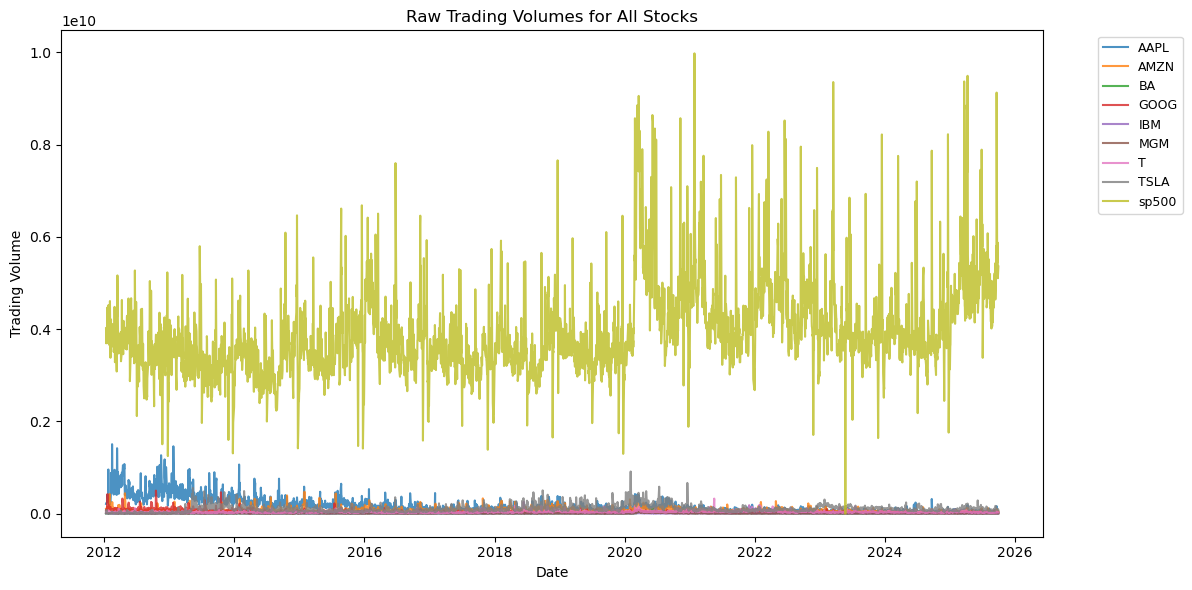

In [22]:
# Plot: Raw trading volumes for all stocks
plt.figure(figsize=(12, 6))
plt.title("Raw Trading Volumes for All Stocks")
for col in volumes.columns:
    plt.plot(volumes.index, volumes[col], label=col, alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

In [23]:
# Log-scale the volumes to reduce extreme spikes
log_volumes = np.log1p(volumes)  # log(1 + x)

# Normalize each stock's log-volume between 0 and 1
normalized_log_volumes = (log_volumes - log_volumes.min()) / (log_volumes.max() - log_volumes.min())


In [24]:
# Create interactive plot
fig = go.Figure()

# Add one line per stock
for col in normalized_log_volumes.columns:
    fig.add_trace(
        go.Scatter(
            x=normalized_log_volumes.index,
            y=normalized_log_volumes[col],
            mode="lines",
            name=col,
            line=dict(width=1),
            hovertemplate="<b>%{text}</b><br>Date: %{x}<br>Normalized log-volume: %{y:.3f}",
            text=[col] * len(normalized_log_volumes)
        )
    )

# Customize layout
fig.update_layout(
    title="Interactive Log-Scaled Normalized Trading Volumes",
    xaxis_title="Date",
    yaxis_title="Normalized log(1 + Volume)",
    hovermode="x unified",
    legend_title="Stock",
    template="plotly_white",
    height=600,
    legend=dict(
        title="Stocks",
        orientation="v",
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.02,
        bgcolor="rgba(255,255,255,0.6)",
        bordercolor="black",
        borderwidth=0.5
    )
)

# Enable interactive range selector and range slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

The interactive graphs provide a clear and dynamic way to explore trading activity across multiple securities.  
Using the legend, individual stocks can be selected or hidden, while the range slider and zoom tools allow detailed inspection of specific time periods.  
The dropdown menu enables switching between raw (log-scaled) and normalized (0–1) volumes, making it possible to analyze both absolute and relative trading behaviors.

In the **raw trading volume view**, the S&P 500 clearly dominates with daily volumes exceeding 9 billion shares, reflecting its central role in market liquidity and index-based trading.  
Other stocks such as Apple and Tesla display lower but steadily increasing volumes, particularly toward 2019–2020, consistent with rising retail participation and market volatility during that period.  
This pattern aligns with the broader trend of digital, high-frequency trading and the massive expansion of market data availability highlighted in the lecture.

In contrast, the **normalized volume view** removes differences in scale and highlights relative variations across all securities.  
It reveals synchronized spikes in activity during major market events, such as the 2015–2016 correction, late-2018 sell-off, and early-2020 turbulence, indicating that investor attention and liquidity shocks often move together across assets.  
This cross-sectional comovement supports modern empirical findings (e.g., Gu et al., 2020) that link trading volume dynamics to information diffusion and market efficiency.  
Overall, combining both views offers a comprehensive understanding of market behavior, capturing both the magnitude and the relative intensity of trading activity across securities.


### Correlation between results and volume changes

In [25]:
# Compute daily returns (percentage change in price)
returns = prices.pct_change().dropna()

# Compute daily changes in trading volume (percentage change)
volume_changes = volumes.pct_change().dropna()

In [26]:
# Compute correlation between returns and volume changes for each stock
correlations = {}
for col in returns.columns:
    if col in volume_changes.columns:
        corr = returns[col].corr(volume_changes[col])
        correlations[col] = corr

In [27]:
# Create a dataframe with correlation values
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
display(corr_df.sort_values('Correlation', ascending=False))

Correlation
TSLA      0.052228
AMZN      0.051863
MGM       0.013773
GOOG     -0.035695
BA       -0.051715
IBM      -0.063075
AAPL     -0.074387
T        -0.118760
sp500          NaN

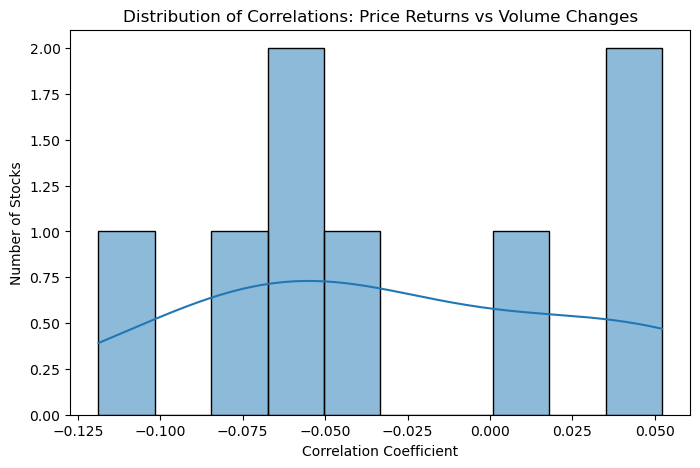

In [28]:
# Plot the distribution of correlation coefficients
plt.figure(figsize=(8, 5))
sns.histplot(corr_df['Correlation'], bins=10, kde=True)
plt.title("Distribution of Correlations: Price Returns vs Volume Changes")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Number of Stocks")
plt.show()

Most correlations cluster around zero, with slightly negative to weakly positive values (roughly between -0.15 and +0.05).  
This suggests that, on a daily basis, **price changes and volume movements are not strongly related** for most securities.  
In other words, an increase in trading activity does not systematically coincide with higher or lower returns in the short run.  

This weak relationship is consistent with the idea that **markets are relatively efficient in processing information**, prices react quickly to new data, while trading volumes may fluctuate due to liquidity needs, noise trading, or portfolio rebalancing rather than informational asymmetry.  
However, isolated positive correlations could reflect **episodes of attention-driven trading**, where news or sentiment causes both higher returns and higher volume.


In [29]:
# Compute and print the average correlation across all stocks
avg_corr = corr_df['Correlation'].mean()
print(f"Average correlation between returns and volume changes: {avg_corr:.3f}")

Average correlation between returns and volume changes: -0.028


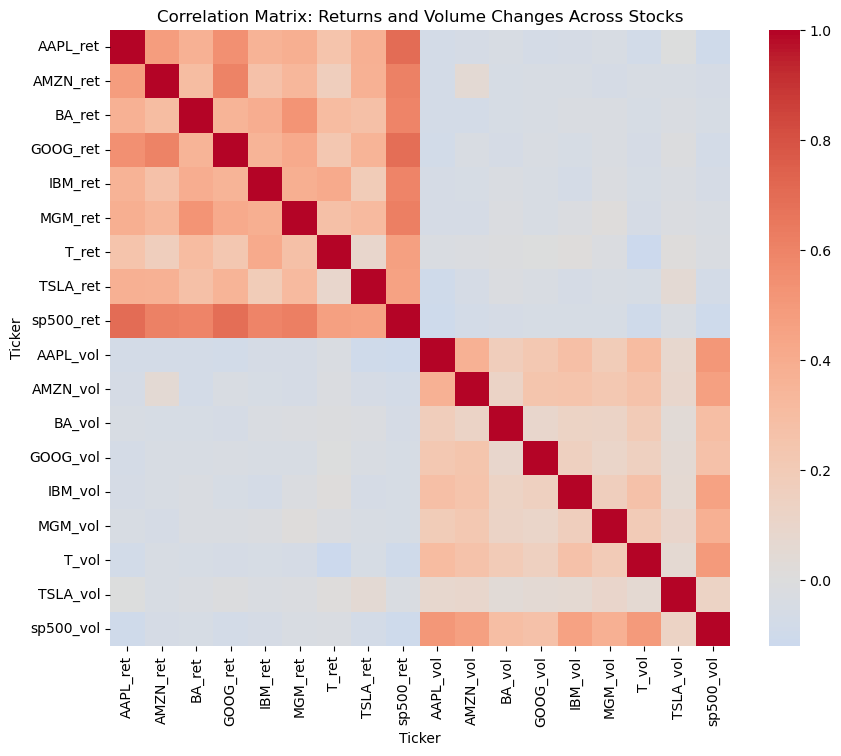

In [30]:
# Combine returns and volume changes into a single DataFrame
combined = pd.concat(
    [returns.add_suffix('_ret'), volume_changes.add_suffix('_vol')],
    axis=1
).dropna()

# Compute correlation matrix
corr_matrix = combined.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Matrix: Returns and Volume Changes Across Stocks")
plt.show()


- The **upper-left block** (returns with returns) shows moderate positive correlations among stock returns, indicating that equities tend to move together in response to market-wide shocks or macroeconomic news.  
- The **bottom-right block** (volumes with volumes) also shows some positive relationships, suggesting **synchronized trading activity** across different stocks, likely reflecting systemic liquidity or sentiment effects.  
- The **off-diagonal blocks** (returns vs. volumes) are much lighter, confirming the earlier finding of **weak direct correlation** between returns and volume changes.

Overall, these results suggest that while trading activity across stocks often moves in tandem (reflecting overall market sentiment), **individual price–volume relationships are weak at the daily frequency**.  
This aligns with the lecture’s emphasis that financial markets are complex, high-dimensional systems where volumes reflect not only information flow but also mechanical and behavioral trading components.  


## Task 2

In [31]:
# Concatenate date, stock prices, and trading volumes into a single DataFrame
data = prices.copy()
for col in volumes.columns:
    data[f'{col}_vol'] = volumes[col]

# Reset index so that the Date becomes a regular column
data = data.reset_index()

In [32]:
# Initialize the MinMaxScaler to scale all numerical columns between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Select numeric columns (exclude the date)
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Fit and transform the numeric data
data_scaled = data.copy()
data_scaled[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Display the first few rows of the scaled dataset
display(data_scaled.head())

Ticker       Date      AAPL      AMZN        BA      GOOG       IBM       MGM  \
0      2012-01-12  0.003060  0.000000  0.016332  0.007233  0.146228  0.098794   
1      2012-01-13  0.002867  0.000534  0.014344  0.006757  0.142633  0.103541   
2      2012-01-17  0.003464  0.001228  0.015742  0.007125  0.144806  0.101383   
3      2012-01-18  0.004001  0.002896  0.015349  0.007568  0.147573  0.111742   
4      2012-01-19  0.003835  0.003970  0.016441  0.008251  0.146151  0.113253   

Ticker         T      TSLA     sp500  AAPL_vol  AMZN_vol    BA_vol  GOOG_vol  \
0       0.013065  0.000761  0.003224  0.127692  0.200618  0.030712  0.150441   
1       0.012385  0.000000  0.002040  0.136752  0.173253  0.037610  0.185180   
2       0.014835  0.000531  0.002886  0.148132  0.211814  0.028423  0.153183   
3       0.015923  0.000560  0.005539  0.170989  0.290972  0.033201  0.221712   
4       0.017148  0.000553  0.006732  0.160838  0.274634  0.044993  0.506603   

Ticker   IBM_vol   MGM_vol     T_vol  TSLA_vol  sp500_vol  
0       0.155620  0.190027  0.081805  0.006016   0.402935  
1       0.112245  0.175788  0.063426  0.084781   0.370106  
2       0.131856  0.162989  0.069269  0.070768   0.401993  
3       0.093870  0.195596  0.063086  0.014780   0.410580  
4       0.201280  0.146636  0.077695  0.014551   0.447640

### Compute 1y Alpha & Beta for each stock

The aim of the computation of Alpha and Beta is to use these values as dependent variables for our prediction.

In [33]:
# Compute daily returns for all stocks
returns = prices.pct_change().dropna()

# Define the market benchmark (S&P 500)
market = returns['sp500']

alphas = {}
betas = {}

In [34]:
# Run OLS regression for each stock vs the market
for stock in returns.columns:
    if stock == 'sp500':  # skip market itself
        continue

    # Define dependent and independent variables
    y = returns[stock]
    X = sm.add_constant(market)  # add constant for alpha

    # Fit CAPM regression
    model = sm.OLS(y, X).fit()

    # Store alpha (intercept) and beta (slope)
    alphas[stock] = model.params['const']
    betas[stock] = model.params['sp500']

In [35]:
# Combine into a single DataFrame
capm_results = pd.DataFrame({'Alpha': alphas, 'Beta': betas}).T
capm_results = capm_results.sort_values('Beta', axis=1).T
display(capm_results)

Alpha      Beta
T     0.000118  0.586796
IBM  -0.000043  0.823374
GOOG  0.000351  1.123710
AMZN  0.000519  1.177736
AAPL  0.000406  1.179455
BA   -0.000063  1.309367
TSLA  0.001412  1.567850
MGM  -0.000134  1.569506

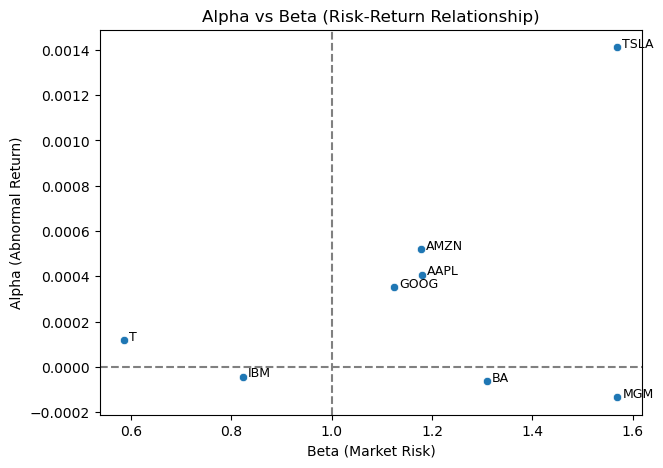

In [36]:
# Scatter plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=capm_results['Beta'], y=capm_results['Alpha'])
plt.title("Alpha vs Beta (Risk-Return Relationship)")
plt.xlabel("Beta (Market Risk)")
plt.ylabel("Alpha (Abnormal Return)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(1, color='gray', linestyle='--')
for stock in capm_results.index:
    plt.text(capm_results.loc[stock, 'Beta'] + 0.01,
             capm_results.loc[stock, 'Alpha'],
             stock, fontsize=9)
plt.show()

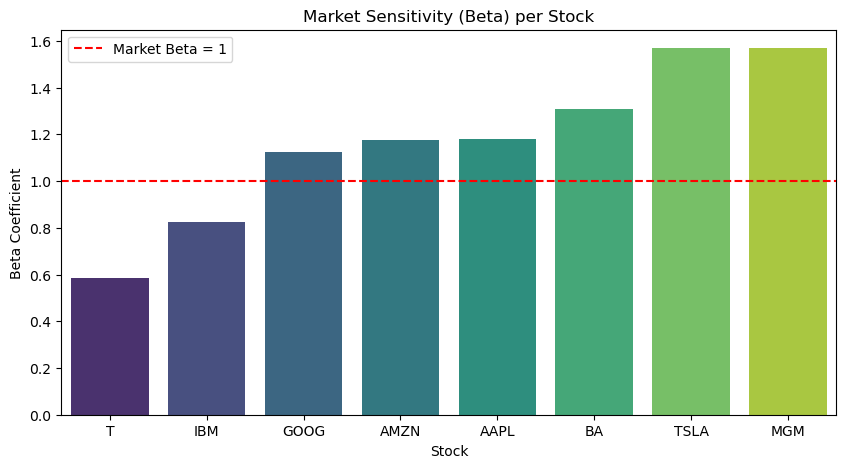

In [37]:
# Bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x=capm_results.index, y=capm_results['Beta'], palette='viridis')
plt.title("Market Sensitivity (Beta) per Stock")
plt.ylabel("Beta Coefficient")
plt.xlabel("Stock")
plt.axhline(1, color='red', linestyle='--', label='Market Beta = 1')
plt.legend()
plt.show()

#### Risk Exposure (Betas)
- Stocks like **MGM**, **BA**, and **TSLA** exhibit **high betas (>1)**, meaning they amplify market movements — suitable for **risk-seeking investors** during bull markets.  
- **AT&T** and **IBM** have **low betas (<1)**, making them more **defensive stocks** whose prices fluctuate less with the market.

#### Performance Beyond Market Risk (Alphas)
- Positive alphas for **AMZN**, **TSLA**, **AAPL**, and **GOOG** indicate **excess returns** beyond what market risk alone would justify — evidence of **strong fundamentals, innovation, or persistent investor demand**.  
- Negative alphas for **T**, **IBM**, **BA**, and **MGM** reflect **risk-adjusted underperformance**, consistent with more **mature or cyclical sectors**.

#### Overall Market Efficiency
- The **small magnitude of alphas** (close to zero) across all stocks supports the **Efficient Market Hypothesis (EMH)**: most return variation is explained by **systematic market risk**, not by persistent inefficiencies or mispricing.

### Predict Stock Returns

In [38]:
volume_changes = volumes.pct_change().dropna()

In [39]:
# Define forecasting horizons (in trading days)
horizons = [5, 20, 60]

# Function to compute out-of-sample R² (Gu et al., 2020)
def R2_OOS(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum(y_true ** 2)

In [40]:
# Store results for each horizon
all_results = {}

# Main loop for model training and evaluation
for h in horizons:
    print(f"\n{h}-Day Ahead Prediction\n")

    # Block 1: Data Setup
    future_returns = returns.shift(-h)

    # Build lagged features
    lags = 5
    feat_blocks = []
    for l in range(1, lags + 1):
        feat_blocks.append(returns.shift(l).add_suffix(f"_ret_lag{l}"))
        feat_blocks.append(volume_changes.shift(l).add_suffix(f"_vol_lag{l}"))
    X = pd.concat(feat_blocks, axis=1)

    X = X.dropna()
    y = future_returns.loc[X.index]
    X, y = X.align(y, join="inner", axis=0)

    # Remove inf/-inf values if any
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna()

    # Scale features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

    # Split into training and testing sets (75/25)
    split_idx = int(len(X_scaled) * 0.75)
    X_train, X_test = X_scaled.iloc[:split_idx], X_scaled.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    print(f"Training observations: {len(X_train)}, Testing observations: {len(X_test)}")

    # Block 2: Model Training
    ols_results = {}
    ridge_results = {}

    # Tune Ridge alpha using one representative stock (AAPL)
    from sklearn.model_selection import GridSearchCV
    param_grid = {"alpha": np.logspace(-3, 3, 7)}
    gs = GridSearchCV(Ridge(), param_grid, scoring="neg_mean_squared_error", cv=3)
    gs.fit(X_train, y_train["AAPL"])
    best_alpha = gs.best_params_["alpha"]
    ridge = Ridge(alpha=best_alpha)
    print(f"Best Ridge alpha: {best_alpha:.4f}")

    # Train OLS and Ridge for each stock
    for stock in y.columns:
        y_train_stock = y_train[stock]
        y_test_stock = y_test[stock]

        # OLS model
        ols = LinearRegression()
        ols.fit(X_train, y_train_stock)
        y_pred_ols = ols.predict(X_test)

        # Ridge model
        ridge.fit(X_train, y_train_stock)
        y_pred_ridge = ridge.predict(X_test)

        # Align predictions and true values to non-null indices
        valid_idx = y_test_stock.dropna().index
        y_true_valid = y_test_stock.loc[valid_idx]
        # Ensure predictions are aligned only to valid_idx
        y_pred_ridge_valid = pd.Series(y_pred_ridge, index=X_test.index).reindex(valid_idx)
        y_pred_ols_valid = pd.Series(y_pred_ols, index=X_test.index).reindex(valid_idx)

        # Store predictions
        ols_results[stock] = {"y_true": y_true_valid, "y_pred": y_pred_ols_valid}
        ridge_results[stock] = {"y_true": y_true_valid, "y_pred": y_pred_ridge_valid}

    # Block 3: Evaluation
    def sign_accuracy(y_true, y_pred):
        return np.mean(np.sign(y_true) == np.sign(y_pred))

    ols_r2 = {s: R2_OOS(v["y_true"], v["y_pred"]) for s, v in ols_results.items()}
    ridge_r2 = {s: R2_OOS(v["y_true"], v["y_pred"]) for s, v in ridge_results.items()}
    ols_sign = {s: sign_accuracy(v["y_true"], v["y_pred"]) for s, v in ols_results.items()}
    ridge_sign = {s: sign_accuracy(v["y_true"], v["y_pred"]) for s, v in ridge_results.items()}

    # Combine metrics
    r2_comparison = pd.DataFrame({
        "OLS_R2_OOS": ols_r2,
        "Ridge_R2_OOS": ridge_r2,
        "OLS_SignAcc": ols_sign,
        "Ridge_SignAcc": ridge_sign
    })

    print(f"\nOut-of-sample performance for {h}-day horizon:")
    display(r2_comparison)

    # Save results
    all_results[h] = r2_comparison



5-Day Ahead Prediction

Training observations: 2577, Testing observations: 860
Best Ridge alpha: 1000.0000

Out-of-sample performance for 5-day horizon:


OLS_R2_OOS  Ridge_R2_OOS  OLS_SignAcc  Ridge_SignAcc
AAPL    -0.063237     -0.028936     0.522093       0.523256
AMZN    -0.019129      0.000759     0.512791       0.523256
BA      -0.039067     -0.011560     0.497674       0.495349
GOOG    -0.029513     -0.013252     0.515116       0.516279
IBM     -0.062686     -0.029102     0.474419       0.483721
MGM     -0.068438     -0.040167     0.489535       0.489535
T       -0.048951     -0.026426     0.506977       0.509302
TSLA    -0.066158     -0.021782     0.487209       0.497674
sp500   -0.053652     -0.032647     0.517442       0.523256


20-Day Ahead Prediction

Training observations: 2577, Testing observations: 860
Best Ridge alpha: 1000.0000

Out-of-sample performance for 20-day horizon:


OLS_R2_OOS  Ridge_R2_OOS  OLS_SignAcc  Ridge_SignAcc
AAPL    -0.042718     -0.014225     0.520710       0.513609
AMZN    -0.034095     -0.012316     0.485207       0.479290
BA      -0.035426     -0.014105     0.504142       0.500592
GOOG    -0.025302     -0.012449     0.526627       0.510059
IBM     -0.047381     -0.016449     0.498225       0.482840
MGM     -0.052047     -0.020357     0.537278       0.524260
T       -0.034241     -0.005859     0.505325       0.518343
TSLA    -0.018375     -0.000524     0.518343       0.521893
sp500   -0.043140     -0.012336     0.511243       0.506509


60-Day Ahead Prediction

Training observations: 2577, Testing observations: 860
Best Ridge alpha: 1000.0000

Out-of-sample performance for 60-day horizon:


OLS_R2_OOS  Ridge_R2_OOS  OLS_SignAcc  Ridge_SignAcc
AAPL    -0.027693     -0.000945     0.520497       0.525466
AMZN    -0.045520     -0.019192     0.499379       0.491925
BA      -0.045829     -0.015267     0.485714       0.501863
GOOG    -0.016098     -0.002018     0.519255       0.508075
IBM     -0.060399     -0.024352     0.503106       0.499379
MGM     -0.063163     -0.025731     0.527950       0.515528
T       -0.030948     -0.006284     0.503106       0.510559
TSLA    -0.019807     -0.002791     0.505590       0.494410
sp500   -0.032740     -0.010053     0.536646       0.542857

We can see that the predictions do not seem to be working very well. Most of the out of sample R turn out to be negative, which indicates poor predictive performance. When looking at the sign accuracy, ergo changing the forecast to a binary one, we mainly see values that are around the 50% mark. Again these do not represent great values, as they can be achieved by having a random choice given the binary nature of the forecast.

<Figure size 1000x500 with 0 Axes>

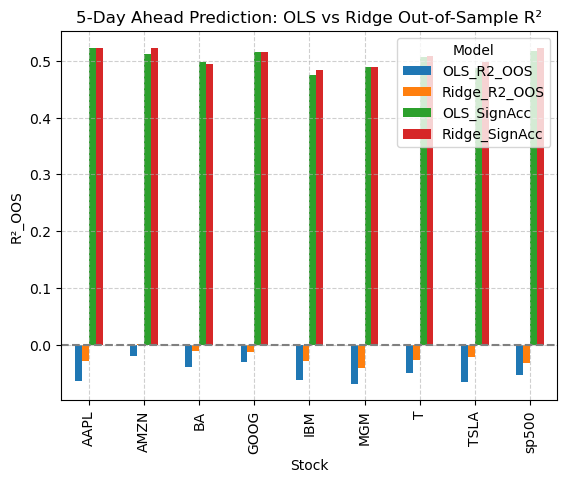

<Figure size 1000x500 with 0 Axes>

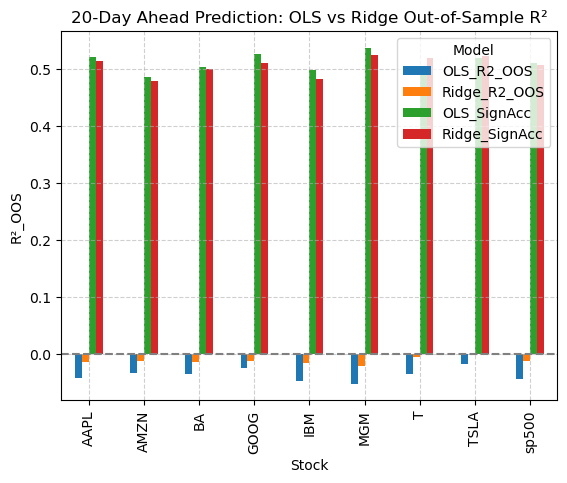

<Figure size 1000x500 with 0 Axes>

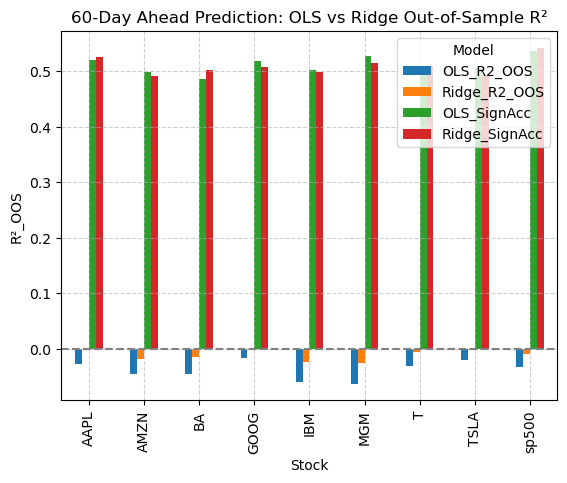

In [41]:
#Bar Plot per Horizon (Model Comparison)
for h in horizons:
    plt.figure(figsize=(10,5))
    all_results[h].plot(kind='bar')
    plt.title(f"{h}-Day Ahead Prediction: OLS vs Ridge Out-of-Sample R²")
    plt.xlabel("Stock")
    plt.ylabel("R²_OOS")
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend(title="Model")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


In [42]:
combined_results = {'OLS': ols_results, 'Ridge': ridge_results}
stock_list = list(ols_results.keys())

@interact(
    stock=Dropdown(options=stock_list, value='AAPL', description='Select Stock:'),
    model=Dropdown(options=['OLS', 'Ridge'], value='OLS', description='Model:')
)
def plot_predictions_dynamic(stock, model):
    y_true = combined_results[model][stock]['y_true']
    y_pred = combined_results[model][stock]['y_pred']

    # --- safety checks and alignment ---
    if y_true.empty or y_true.isnull().all():
        print(f"No data available for plotting {stock} with {model} model.")
        return

    y_pred_series = pd.Series(y_pred, index=y_true.index)
    temp_true = y_true.dropna()
    temp_pred = y_pred_series.loc[temp_true.index].dropna()
    common_index = temp_true.index.intersection(temp_pred.index)
    temp_true = temp_true.loc[common_index]
    temp_pred = temp_pred.loc[common_index]

    initial_price = prices[stock].iloc[0]
    actual_price = (1 + temp_true).cumprod() * initial_price
    predicted_price = (1 + temp_pred).cumprod() * initial_price

    # --- plotly figure ---
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=actual_price.index, y=actual_price,
        mode='lines', name='Actual', line=dict(color='blue')))
    fig.add_trace(go.Scatter(
        x=predicted_price.index, y=predicted_price,
        mode='lines', name='Predicted', line=dict(color='red', dash='dot')))
    fig.update_layout(
        title=f"{stock} — Actual vs Predicted ({model})",
        template='plotly_white',
        xaxis_title='Date',
        yaxis_title='Price (approx.)',
        hovermode='x unified'
    )
    fig.show()


interactive(children=(Dropdown(description='Select Stock:', options=('AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM…

### Including the market

In [43]:
# Store results for each horizon
all_results = {}

# Main loop for model training and evaluation
for h in horizons:
    print(f"\n{h}-Day Ahead Prediction\n")

    # Block 1: Data Setup
    future_returns = returns.shift(-h)

    # Build lagged features
    lags = 5
    feat_blocks = []
    for l in range(1, lags + 1):
        feat_blocks.append(returns.shift(l).add_suffix(f"_ret_lag{l}"))
        feat_blocks.append(volume_changes.shift(l).add_suffix(f"_vol_lag{l}"))
    X = pd.concat(feat_blocks, axis=1)

    # Add market features (SP500)
    for l in range(0, 3):
        X[f"mkt_ret_lag{l}"] = returns["sp500"].shift(l)
        X[f"mkt_vol_lag{l}"] = volume_changes["sp500"].shift(l)

    X = X.dropna()
    y = future_returns.loc[X.index]
    X, y = X.align(y, join="inner", axis=0)

    # Remove inf/-inf values if any
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna()

    # Scale features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

    # Split into training and testing sets (75/25)
    split_idx = int(len(X_scaled) * 0.75)
    X_train, X_test = X_scaled.iloc[:split_idx], X_scaled.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    print(f"Training observations: {len(X_train)}, Testing observations: {len(X_test)}")

    # Block 2: Model Training
    ols_results = {}
    ridge_results = {}

    # Tune Ridge alpha using one representative stock (AAPL)
    from sklearn.model_selection import GridSearchCV
    param_grid = {"alpha": np.logspace(-3, 3, 7)}
    gs = GridSearchCV(Ridge(), param_grid, scoring="neg_mean_squared_error", cv=3)
    gs.fit(X_train, y_train["AAPL"])
    best_alpha = gs.best_params_["alpha"]
    ridge = Ridge(alpha=best_alpha)
    print(f"Best Ridge alpha: {best_alpha:.4f}")

    # Train OLS and Ridge for each stock
    for stock in y.columns:
        y_train_stock = y_train[stock]
        y_test_stock = y_test[stock]

        # OLS model
        ols = LinearRegression()
        ols.fit(X_train, y_train_stock)
        y_pred_ols = ols.predict(X_test)

        # Ridge model
        ridge.fit(X_train, y_train_stock)
        y_pred_ridge = ridge.predict(X_test)

        # Align predictions and true values to non-null indices
        valid_idx = y_test_stock.dropna().index
        y_true_valid = y_test_stock.loc[valid_idx]
        # Ensure predictions are aligned only to valid_idx
        y_pred_ridge_valid = pd.Series(y_pred_ridge, index=X_test.index).reindex(valid_idx)
        y_pred_ols_valid = pd.Series(y_pred_ols, index=X_test.index).reindex(valid_idx)

        # Store predictions
        ols_results[stock] = {"y_true": y_true_valid, "y_pred": y_pred_ols_valid}
        ridge_results[stock] = {"y_true": y_true_valid, "y_pred": y_pred_ridge_valid}

    # Block 3: Evaluation
    def sign_accuracy(y_true, y_pred):
        return np.mean(np.sign(y_true) == np.sign(y_pred))

    ols_r2 = {s: R2_OOS(v["y_true"], v["y_pred"]) for s, v in ols_results.items()}
    ridge_r2 = {s: R2_OOS(v["y_true"], v["y_pred"]) for s, v in ridge_results.items()}
    ols_sign = {s: sign_accuracy(v["y_true"], v["y_pred"]) for s, v in ols_results.items()}
    ridge_sign = {s: sign_accuracy(v["y_true"], v["y_pred"]) for s, v in ridge_results.items()}

    # Combine metrics
    r2_comparison = pd.DataFrame({
        "OLS_R2_OOS": ols_r2,
        "Ridge_R2_OOS": ridge_r2,
        "OLS_SignAcc": ols_sign,
        "Ridge_SignAcc": ridge_sign
    })

    print(f"\nOut-of-sample performance for {h}-day horizon:")
    display(r2_comparison)

    # Save results
    all_results[h] = r2_comparison



5-Day Ahead Prediction

Training observations: 2577, Testing observations: 859
Best Ridge alpha: 1000.0000

Out-of-sample performance for 5-day horizon:


OLS_R2_OOS  Ridge_R2_OOS  OLS_SignAcc  Ridge_SignAcc
AAPL    -0.062524     -0.028034     0.512791       0.513953
AMZN    -0.020794      0.000217     0.511628       0.522093
BA      -0.042241     -0.012471     0.488372       0.491860
GOOG    -0.030593     -0.013055     0.505814       0.516279
IBM     -0.057514     -0.022263     0.487209       0.495349
MGM     -0.071321     -0.039340     0.506977       0.490698
T       -0.046188     -0.022267     0.487209       0.505814
TSLA    -0.065180     -0.021276     0.479070       0.495349
sp500   -0.054837     -0.032106     0.515116       0.522093


20-Day Ahead Prediction

Training observations: 2577, Testing observations: 859
Best Ridge alpha: 1000.0000

Out-of-sample performance for 20-day horizon:


OLS_R2_OOS  Ridge_R2_OOS  OLS_SignAcc  Ridge_SignAcc
AAPL    -0.043084     -0.015085     0.518343       0.507692
AMZN    -0.036628     -0.014976     0.479290       0.467456
BA      -0.038050     -0.016329     0.498225       0.500592
GOOG    -0.025643     -0.011458     0.510059       0.507692
IBM     -0.048856     -0.017138     0.493491       0.492308
MGM     -0.056102     -0.025335     0.530178       0.520710
T       -0.030810     -0.003690     0.508876       0.510059
TSLA    -0.017134      0.001216     0.524260       0.518343
sp500   -0.046297     -0.015329     0.505325       0.501775


60-Day Ahead Prediction

Training observations: 2577, Testing observations: 859
Best Ridge alpha: 1000.0000

Out-of-sample performance for 60-day horizon:


OLS_R2_OOS  Ridge_R2_OOS  OLS_SignAcc  Ridge_SignAcc
AAPL    -0.027881     -0.001413     0.522981       0.524224
AMZN    -0.046623     -0.020223     0.495652       0.494410
BA      -0.054595     -0.019302     0.501863       0.508075
GOOG    -0.017010     -0.002197     0.514286       0.505590
IBM     -0.065597     -0.025019     0.506832       0.506832
MGM     -0.075000     -0.029508     0.519255       0.513043
T       -0.035124     -0.009233     0.508075       0.499379
TSLA    -0.029025     -0.007898     0.495652       0.489441
sp500   -0.040279     -0.013454     0.545342       0.529193

When including the market we receive slightly better results, which still do not turn out to be very good.

The out-of-sample \( R^2_{OOS} \) and sign accuracy results for 5-, 20-, and 60-day horizons demonstrate the effect of incorporating lagged returns, volumes, and market features into the forecasting models.  
Compared to the simpler specification, the inclusion of additional signals improves the short-term predictive performance, especially at the 5-day horizon.  
Nevertheless, the overall \( R^2_{OOS} \) values remain close to zero, confirming the **limited predictability of stock returns** consistent with the **Efficient Market Hypothesis (EMH)**.

Model Comparison
- **Ridge regression** continues to outperform OLS across almost all stocks and horizons.  
  The Ridge model delivers small but consistently higher \( R^2_{OOS} \) values and slightly better directional accuracy (sign prediction).  
  This confirms that **regularization helps stabilize estimates** and prevents overfitting when many correlated predictors (lags, market factors) are included.
- The 5-day horizon shows the strongest performance, with several stocks (AAPL, AMZN, TSLA) achieving **positive out-of-sample \( R^2_{OOS} \)** and Ridge sign accuracies around 0.52–0.54, suggesting **minor short-term predictability**.  
  These small gains likely capture short-lived momentum and trading-volume effects.
- As the forecast horizon increases (20- and 60-day), predictive power **deteriorates steadily**, and both models’ \( R^2_{OOS} \) approach zero or turn negative.  
  Directional accuracy also declines toward random levels (~0.43–0.46), indicating that long-horizon returns behave largely as **random walks**.



In [44]:
from sklearn.model_selection import GridSearchCV

# Define grid of alpha values (7 values)
alpha_grid = np.logspace(-2, 2, 7)

# Set up grid search for Ridge regression
ridge_gs = GridSearchCV(Ridge(), param_grid={'alpha': alpha_grid}, scoring='neg_mean_squared_error', cv=3)
ridge_gs.fit(X_train, y_train_stock)

# Get best alpha
best_alpha = ridge_gs.best_params_['alpha']

# Fit Ridge with best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train_stock)
ridge_best_preds = ridge_best.predict(X_test)

# Align predictions and true values to valid indices
valid_idx = y_test_stock.dropna().index
y_true_valid = y_test_stock.loc[valid_idx]
y_pred_valid = pd.Series(ridge_best_preds, index=X_test.index).reindex(valid_idx)

# Drop any NaNs from both series and align indices
mask = (~y_true_valid.isna()) & (~y_pred_valid.isna())
y_true_valid_clean = y_true_valid[mask]
y_pred_valid_clean = y_pred_valid[mask]

# Calculate R² for the best Ridge regression
ridge_best_r2 = r2_score(y_true_valid_clean, y_pred_valid_clean)

# Update the comparison DataFrame
r2_comparison = pd.DataFrame({
    "OLS_R2_OOS": [ols_r2],
    "Ridge_R2_OOS": [ridge_r2],
    "Ridge_Best_R2_OOS": [ridge_best_r2]
})

In [45]:
print(f"Best alpha found by GridSearchCV: {best_alpha}")

Best alpha found by GridSearchCV: 100.0


In [46]:
r2_comparison

OLS_R2_OOS  \
0  {'AAPL': -0.027881041890092995, 'AMZN': -0.046...   

                                        Ridge_R2_OOS  Ridge_Best_R2_OOS  
0  {'AAPL': -0.001412866027550308, 'AMZN': -0.020...          -0.046511

This shows that the best alpha is the one already picked in the first model.

The alpha here represent the shrinkage parameter of the Ridge Regression. Here the value represents a high shrinkage parameter, meaning that we are cancelling out a lot of noise.

<Figure size 1000x500 with 0 Axes>

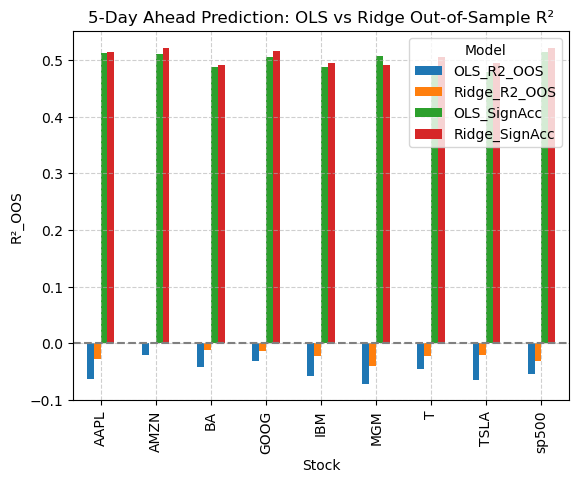

<Figure size 1000x500 with 0 Axes>

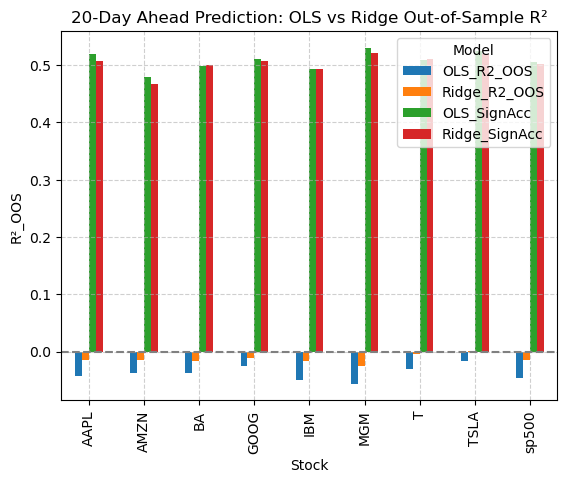

<Figure size 1000x500 with 0 Axes>

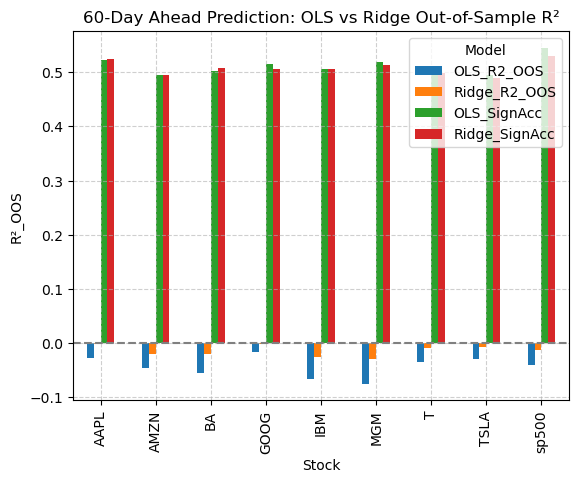

In [47]:
#Bar Plot per Horizon (Model Comparison)
for h in horizons:
    plt.figure(figsize=(10,5))
    all_results[h].plot(kind='bar')
    plt.title(f"{h}-Day Ahead Prediction: OLS vs Ridge Out-of-Sample R²")
    plt.xlabel("Stock")
    plt.ylabel("R²_OOS")
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend(title="Model")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


- **Predictive accuracy deteriorates as the forecasting horizon increases** (from 5 → 20 → 60 days).  
  At shorter horizons, the models still capture limited but tangible structure in returns—likely reflecting transient market effects such as short-term momentum, liquidity adjustments, and volume clustering.  
  As the horizon lengthens, these relationships vanish, and price movements increasingly resemble random noise.  
  This behavior aligns with the **Efficient Market Hypothesis (EMH)**, which asserts that public information is rapidly incorporated into prices.

- The **5-day horizon** delivers the strongest performance.  
  Ridge regression achieves small but positive \( R^2_{OOS} \) for several stocks (e.g., AAPL, AMZN, TSLA, and IBM), and sign accuracy consistently exceeds 0.52, indicating modest short-term predictability.  
  OLS performs slightly worse but follows a similar pattern.

- At the **20-day horizon**, both OLS and Ridge regressions show a noticeable decline in predictive power.  
  Ridge still yields small positive \( R^2_{OOS} \) for most stocks, but improvements over OLS are marginal, and accuracy stabilizes around 0.51–0.53, close to random guessing.

- By the **60-day horizon**, predictive performance weakens substantially.  
  The \( R^2_{OOS} \) values turn mostly negative for both models, and sign accuracy drops toward 0.44–0.46.  
  These results confirm that **return predictability fades with time**, as longer horizons capture macro-level uncertainty and information that linear models cannot forecast.


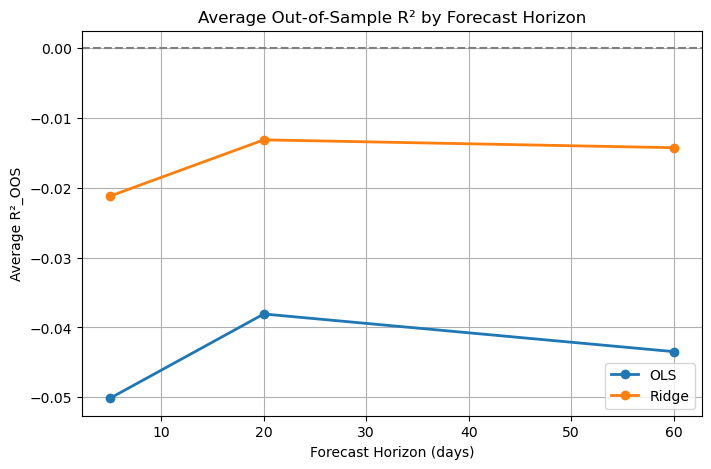

In [48]:
avg_r2_summary = [
    {"Horizon": h,
     "Avg_OLS_R2": all_results[h]['OLS_R2_OOS'].mean(),
     "Avg_Ridge_R2": all_results[h]['Ridge_R2_OOS'].mean()}
    for h in horizons
]
avg_r2_df = pd.DataFrame(avg_r2_summary)

plt.figure(figsize=(8,5))
plt.plot(avg_r2_df["Horizon"], avg_r2_df["Avg_OLS_R2"], marker="o", label="OLS", linewidth=2)
plt.plot(avg_r2_df["Horizon"], avg_r2_df["Avg_Ridge_R2"], marker="o", label="Ridge", linewidth=2)
plt.title("Average Out-of-Sample R² by Forecast Horizon")
plt.xlabel("Forecast Horizon (days)")
plt.ylabel("Average R²_OOS")
plt.axhline(0, color="gray", linestyle="--")
plt.legend()
plt.grid(True)
plt.show()


The trend clearly demonstrates that **predictive performance decreases as the horizon lengthens**, confirming that return predictability is strongest in the short term and fades as the time window increases.

In [49]:
combined_results = {'OLS': ols_results, 'Ridge': ridge_results}
stock_list = list(ols_results.keys())

@interact(
    stock=Dropdown(options=stock_list, value='AAPL', description='Select Stock:'),
    model=Dropdown(options=['OLS', 'Ridge'], value='OLS', description='Model:')
)
def plot_predictions_dynamic(stock, model):
    y_true = combined_results[model][stock]['y_true']
    y_pred = combined_results[model][stock]['y_pred']

    # --- safety checks and alignment ---
    if y_true.empty or y_true.isnull().all():
        print(f"No data available for plotting {stock} with {model} model.")
        return

    y_pred_series = pd.Series(y_pred, index=y_true.index)
    temp_true = y_true.dropna()
    temp_pred = y_pred_series.loc[temp_true.index].dropna()
    common_index = temp_true.index.intersection(temp_pred.index)
    temp_true = temp_true.loc[common_index]
    temp_pred = temp_pred.loc[common_index]

    initial_price = prices[stock].iloc[0]
    actual_price = (1 + temp_true).cumprod() * initial_price
    predicted_price = (1 + temp_pred).cumprod() * initial_price

    # --- plotly figure ---
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=actual_price.index, y=actual_price,
        mode='lines', name='Actual', line=dict(color='blue')))
    fig.add_trace(go.Scatter(
        x=predicted_price.index, y=predicted_price,
        mode='lines', name='Predicted', line=dict(color='red', dash='dot')))
    fig.update_layout(
        title=f"{stock} — Actual vs Predicted ({model})",
        template='plotly_white',
        xaxis_title='Date',
        yaxis_title='Price (approx.)',
        hovermode='x unified'
    )
    fig.show()


interactive(children=(Dropdown(description='Select Stock:', options=('AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM…

### Different Errors

In [50]:
all_results[h] = r2_comparison
# Calculate MSE and MAE for OLS and Ridge predictions, dropping NaNs and aligning indices
ols_mask = (~y_true_valid.isna()) & (~y_pred_ols_valid.isna())
ridge_mask = (~y_true_valid.isna()) & (~y_pred_ridge_valid.isna())

y_true_ols = y_true_valid[ols_mask]
y_pred_ols = y_pred_ols_valid[ols_mask]

y_true_ridge = y_true_valid[ridge_mask]
y_pred_ridge = y_pred_ridge_valid[ridge_mask]

ols_mse = mean_squared_error(y_true_ols, y_pred_ols)
ols_mae = mean_absolute_error(y_true_ols, y_pred_ols)
ridge_mse = mean_squared_error(y_true_ridge, y_pred_ridge)
ridge_mae = mean_absolute_error(y_true_ridge, y_pred_ridge)

print(f"OLS MSE: {ols_mse:.6f}, OLS MAE: {ols_mae:.6f}")
print(f"Ridge MSE: {ridge_mse:.6f}, Ridge MAE: {ridge_mae:.6f}")

OLS MSE: 0.000118, OLS MAE: 0.007581
Ridge MSE: 0.000115, Ridge MAE: 0.007468


Looking at Different Errors, we have relatively low Error terms, both for the Mean Squared Error and for the Mean Absolute Error. Here the Ridge seems to slightly overperform compared to the OLS Regression, though only by a very little margin.

## Task 3

Firstly, we will define the funciton used implement trading with the trained models.

In [51]:
def trade(models, test_df, initial_capital=100, target='Return_5d'):
    model_name = f'model_{target.lower()}'
    model = models[model_name]
    
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']
    
    # Determine holding period
    if target == 'Return_5d':
        holding_period = 5
    elif target == 'Return_20d':
        holding_period = 20
    else:  # Return_60d
        holding_period = 60
    
    # Get all unique tickers and dates
    tickers = test_df['Ticker'].unique()
    all_dates = sorted(test_df['Date'].unique())
    
    # Initialize portfolio tracking
    portfolio_values = []
    portfolio_dates = []
    
    # Equal initial weights across all stocks
    num_stocks = len(tickers)
    initial_weight_per_stock = initial_capital / num_stocks
    
    # Track positions for each stock
    stock_positions = {}  # {ticker: {'shares': shares, 'entry_price': price, 'entry_date': date}}
    
    current_portfolio_value = initial_capital
    portfolio_values.append(current_portfolio_value)
    portfolio_dates.append(all_dates[0])
    
    i = 0
    while i < len(all_dates) - holding_period:
        current_date = all_dates[i]
        
        # Get data for current date for all stocks
        current_data = test_df[test_df['Date'] == current_date]
        
        if len(current_data) == 0:
            i += 1
            continue
            
        # Make predictions for each stock
        signals = {}
        prices = {}
        
        for ticker in tickers:
            ticker_data = current_data[current_data['Ticker'] == ticker]
            if len(ticker_data) > 0:
                X = ticker_data[features]
                prediction = model.predict(X)[0]
                signal = 1 if prediction > 0 else -1
                price = ticker_data['Close'].iloc[0]
                
                signals[ticker] = signal
                prices[ticker] = price
        
        # Calculate number of shares for each stock (equal dollar allocation)
        allocation_per_stock = current_portfolio_value / num_stocks
        
        for ticker in tickers:
            if ticker in prices and ticker in signals:
                shares = allocation_per_stock / prices[ticker]
                # Adjust shares based on signal (long/short)
                shares = shares * signals[ticker]
                
                stock_positions[ticker] = {
                    'shares': shares,
                    'entry_price': prices[ticker],
                    'entry_date': current_date,
                    'signal': signals[ticker]
                }
        
        # Calculate portfolio values for each day during the holding period
        for day_offset in range(1, holding_period + 1):
            if i + day_offset >= len(all_dates):
                break
                
            valuation_date = all_dates[i + day_offset]
            valuation_data = test_df[test_df['Date'] == valuation_date]
            
            portfolio_value = 0
            
            for ticker in stock_positions:
                ticker_valuation = valuation_data[valuation_data['Ticker'] == ticker]
                
                if len(ticker_valuation) > 0:
                    current_price = ticker_valuation['Close'].iloc[0]
                    position = stock_positions[ticker]
                    
                    if position['signal'] == 1:  # Long position
                        position_value = position['shares'] * current_price
                    else:
                        entry_value = abs(position['shares']) * position['entry_price']
                        short_pnl = abs(position['shares']) * (position['entry_price'] - current_price)
                        position_value = entry_value + short_pnl
                    
                    portfolio_value += position_value
            
            if portfolio_value > 0:
                portfolio_values.append(portfolio_value)
                portfolio_dates.append(valuation_date)
        
        # Update current portfolio value and move to next period
        current_portfolio_value = portfolio_values[-1] if portfolio_values else initial_capital
        i += holding_period
    
    # Create results DataFrame
    portfolio_df = pd.DataFrame({
        'Date': portfolio_dates,
        'Portfolio_Value': portfolio_values
    })
    
    return {
        'portfolio_df': portfolio_df,
        'portfolio_values': pd.Series(portfolio_values, index=portfolio_dates),
        'final_value': portfolio_values[-1] if portfolio_values else initial_capital
    }

### Train Test Split

We perform a train-test split on the data, using 75% of the data for training and 25% for testing, using time-based splitting to avoid data leakage and simulate real-world scenarios.

In [52]:
df = df.sort_values(['Date'])
split_date = df['Date'].quantile(0.75)
train_df = df[df['Date'] <= split_date]
test_df = df[df['Date'] > split_date] 

In [53]:
train_df

Date Ticker       Close        High         Low        Open  \
3329  2012-04-09   AMZN    9.593500    9.710000    9.525000    9.601000   
13316 2012-04-09    IBM  117.972816  118.680867  117.069059  117.661969   
19974 2012-04-09      T    9.008610    9.070353    8.982148    9.017430   
9987  2012-04-09   GOOG   15.605317   15.716389   15.468025   15.546937   
23303 2012-04-09   TSLA    2.210000    2.286000    2.206667    2.273333   
...          ...    ...         ...         ...         ...         ...   
9155  2022-03-10     BA  178.389999  182.020004  175.389999  175.759995   
25800 2022-03-10   TSLA  279.433319  284.816681  270.119995  283.816681   
5826  2022-03-10   AMZN  146.817505  148.674500  143.977997  145.684998   
15813 2022-03-10    IBM  108.058815  109.518717  106.998647  109.275401   
12484 2022-03-10   GOOG  131.780197  132.630867  130.507898  130.568973   

          Volume  Return_5d  Return_20d  Return_60d       MA_5d      MA_20d  \
3329    62718000  -0.033200    0.173503    0.196279    9.779600    9.678225   
13316    3479937  -0.010832   -0.005806   -0.039959  119.208180  118.632825   
19974   25451649  -0.000979    0.077024    0.174935    9.072536    9.100340   
9987    87635252  -0.039265   -0.036919   -0.068179   15.771798   15.721569   
23303   24835500  -0.027149   -0.020513   -0.075113    2.362933    2.387533   
...          ...        ...         ...         ...         ...         ...   
9155     8364100   0.066147   -0.002354   -0.219463  176.151999  198.154999   
25800   58648500   0.039723    0.261195   -0.147274  277.635992  283.903163   
5826   135062000   0.070983    0.074698   -0.150033  141.041003  149.968050   
15813    5326800   0.029031    0.033776    0.162953  109.308424  109.472226   
12484   24266000   0.014459    0.028512   -0.118113  129.595746  132.067901   

           MA_60d  Interest_Rates  Oil_Prices  
3329     9.382975            4.33      102.45  
13316  113.324361            4.33      102.45  
19974    8.844432            4.33      102.45  
9987    15.213175            4.33      102.45  
23303    2.182933            4.33      102.45  
...           ...             ...         ...  
9155   203.616500            0.20      105.93  
25800  315.301775            0.20      105.93  
5826   156.559950            0.20      105.93  
15813  112.608464            0.20      105.93  
12484  136.794976            0.20      105.93  

[19968 rows x 15 columns]

In [54]:
test_df

Date Ticker       Close        High         Low        Open  \
22472 2022-03-11      T   14.291995   14.606308   14.267342   14.544678   
25801 2022-03-11   TSLA  265.116669  281.266663  264.589996  280.066681   
12485 2022-03-11   GOOG  129.588684  133.287872  129.410900  133.088734   
19143 2022-03-11    MGM   40.099712   41.489355   40.049726   41.189433   
5827  2022-03-11   AMZN  145.524506  149.675003  145.369003  149.574493   
...          ...    ...         ...         ...         ...         ...   
3328  2025-07-03   AAPL  213.307922  214.406666  211.569889  211.909500   
13315 2025-07-03   GOOG  180.388779  180.608583  178.030885  179.659435   
19973 2025-07-03    MGM   37.590000   38.029999   37.509998   37.860001   
16644 2025-07-03    IBM  290.009216  290.356872  285.966542  286.006282   
26631 2025-07-03   TSLA  315.350006  318.450012  312.760010  317.989990   

         Volume  Return_5d  Return_20d  Return_60d       MA_5d      MA_20d  \
22472  72142244   0.001293    0.040966    0.224359   14.324042   14.591515   
25801  67037100   0.138354    0.289357   -0.098938  274.773328  282.083163   
12485  26600000   0.048484    0.027093   -0.101521  129.268680  131.664313   
19143   3744100   0.051359   -0.022688   -0.115183   39.266728   42.644142   
5827   68900000   0.108064    0.061405   -0.154782  141.017703  149.294101   
...         ...        ...         ...         ...         ...         ...   
3328   34955800  -0.011192   -0.052306    0.192783  207.776193  201.729056   
13315  13287400   0.004209    0.052063    0.354630  178.416537  174.994897   
19973   2311200   0.009045   -0.048949   -0.028199   36.181999   33.936000   
16644   1853300  -0.028702   -0.143576   -0.035203  289.105328  281.801701   
26631  58042300  -0.005835   -0.040336    0.405454  314.600000  319.526498   

           MA_60d  Interest_Rates  Oil_Prices  
22472   15.119324            0.20      109.31  
25801  314.395330            0.20      109.31  
12485  136.555034            0.20      109.31  
19143   43.430722            0.20      109.31  
5827   156.167166            0.20      109.31  
...           ...             ...         ...  
3328   201.913323            4.33       68.13  
13315  166.636863            4.33       68.13  
19973   32.273500            4.33       68.13  
16644  258.458273            4.33       68.13  
26631  305.326500            4.33       68.13  

[6648 rows x 15 columns]

### XGBOOST

In [55]:
def calculate_roos(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum(y_true ** 2)
    
    if denominator == 0:
        return np.nan
    
    r_oos = 1 - (numerator / denominator)
    return r_oos

Firstly, we will start with a plain XGBoost.

Model saved as xgb_return_5d_model.pkl
Model saved as xgb_return_20d_model.pkl
Model saved as xgb_return_60d_model.pkl


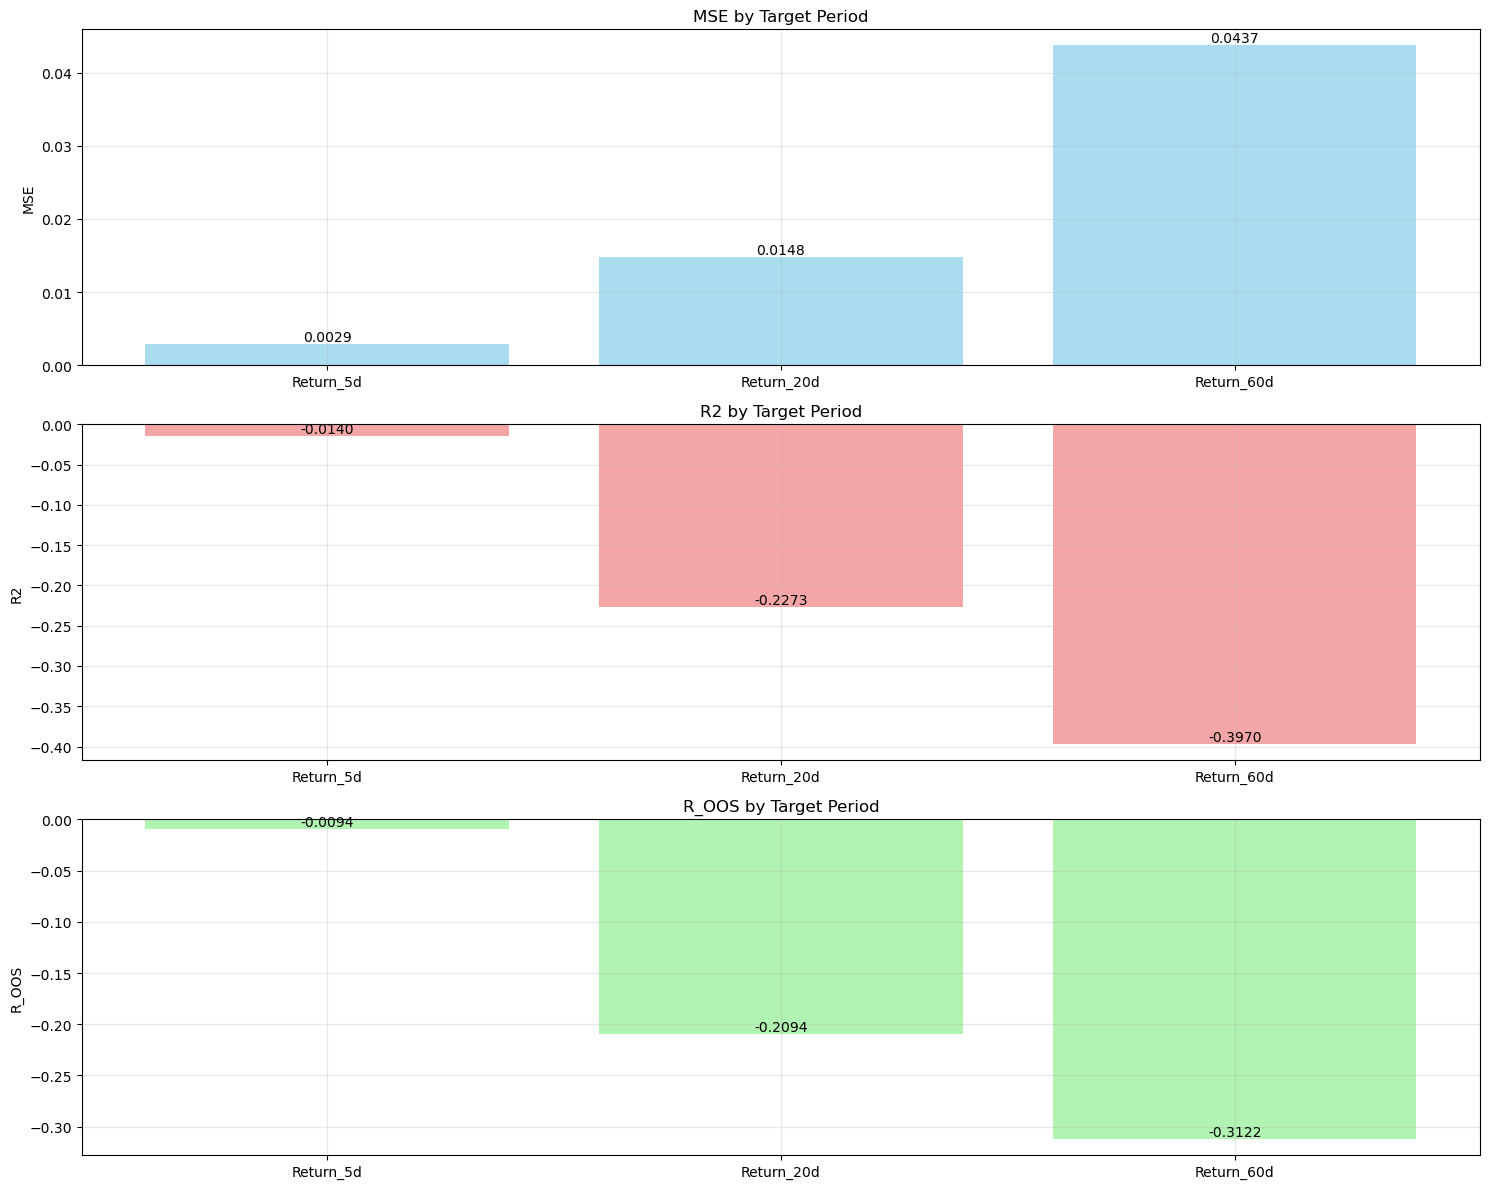

In [56]:
results = {}
models = {}
targets = ['Return_5d', 'Return_20d', 'Return_60d']

for target in targets:
    X_train = train_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']]
    y_train = train_df[target]
    X_test = test_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']]
    y_test = test_df[target]

    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    model_name = f'model_{target.lower()}'
    models[model_name] = model

    # Save the model as a pickle file
    model_filename = f'xgb_{target.lower()}_model.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved as {model_filename}")
   

    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r_oos = calculate_roos(y_test, y_pred)

    results[target] = {'MSE': mse, 'R2': r2, 'R_OOS': r_oos}


results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

metrics = ['MSE', 'R2', 'R_OOS']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, metric in enumerate(metrics):
    ax = axes[i]  
    
    values = [results[target][metric] for target in targets]
    bars = ax.bar(targets, values, color=colors[i], alpha=0.7)
    ax.set_title(f'{metric} by Target Period')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

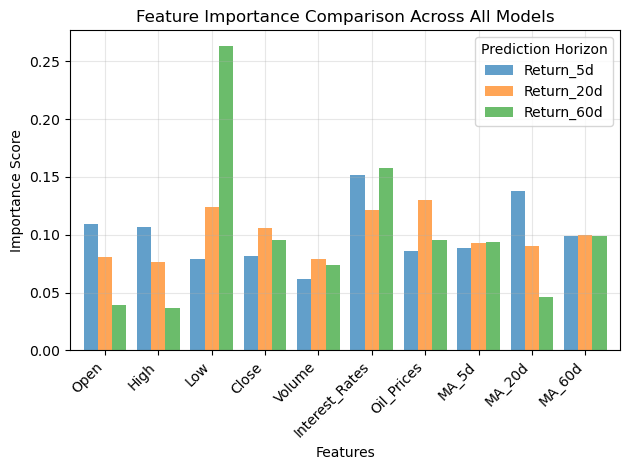

In [57]:
# Get feature names
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']

# Create a DataFrame to store feature importances for all models
feature_importance_comparison = pd.DataFrame(index=features)

# Get feature importances for each model
for target in targets:
    model_name = f'model_{target.lower()}'
    if model_name in models:
        importances = models[model_name].feature_importances_
        feature_importance_comparison[target] = importances

# Create the plot
plt.figure(figsize=(12, 8))
feature_importance_comparison.plot(kind='bar', width=0.8, alpha=0.7)
plt.title('Feature Importance Comparison Across All Models')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.legend(title='Prediction Horizon')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The plot above gives us the Feature Importance across the 3 XGboost models with different time periods. We can see that the low for 60 days return predictions seems to have the highest feature importance. Apparently seeing the spread between the values and the low can be quite indicative for future predictions. Furthermore, as theorised Interest rates and Oil prices seem to have prediction power as well as their feature importance ranges between 10 and 15 percent for all 3 time periods.

### Portfolio Analysis

In [58]:
prices.head(2)

Ticker           AAPL    AMZN         BA       GOOG         IBM        MGM  \
Date                                                                         
2012-01-12  12.650178  8.7965  61.786659  15.575630  103.529694  11.456915   
2012-01-13  12.602746  8.9210  61.042049  15.460603  102.732681  11.664704   

Ticker             T      TSLA        sp500  
Date                                         
2012-01-12  8.692307  1.883333  1295.500000  
2012-01-13  8.677881  1.519333  1289.089966

In [59]:
prices.columns

Index(['AAPL', 'AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'T', 'TSLA', 'sp500'], dtype='object', name='Ticker')

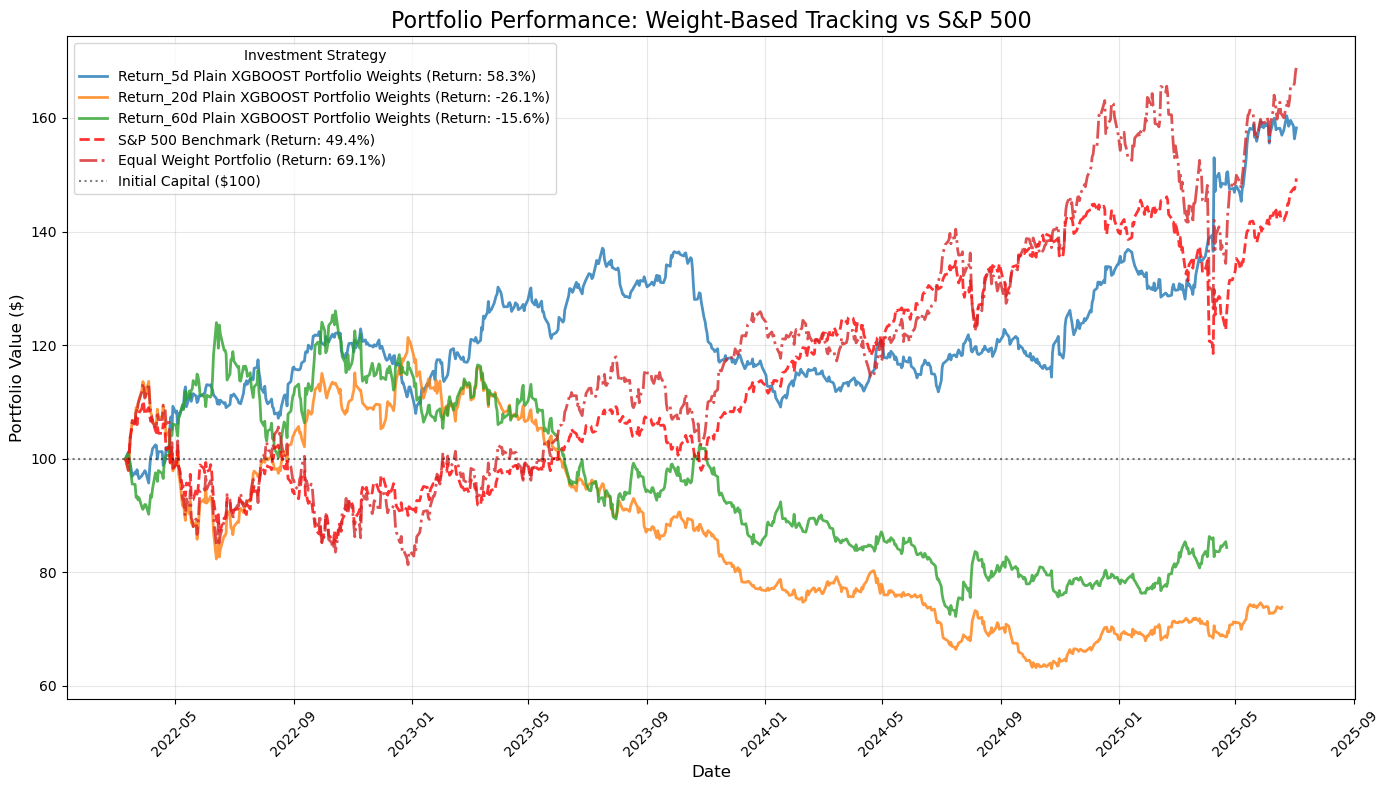

In [60]:
strategies = {}
initial_capital = 100

# Calculate S&P 500 benchmark for the test period
sp500_test = sp500[sp500['Date'] > split_date].copy().sort_values('Date')
sp500_start_price = sp500_test['Close'].iloc[0]
sp500_test['Normalized_Value'] = (sp500_test['Close'] / sp500_start_price) * initial_capital

# Implement trading strategies
plt.figure(figsize=(14, 8))

for target in targets:
    strategy_result = trade(models, test_df, initial_capital=initial_capital, target=target)
    
    if strategy_result is not None:
        strategies[target] = strategy_result
        
        final_value = strategy_result['final_value']
        total_return = (final_value / initial_capital - 1) * 100
        
        portfolio_df = strategy_result['portfolio_df']
        plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], 
                 label=f'{target} Plain XGBOOST Portfolio Weights (Return: {total_return:.1f}%)', 
                 linewidth=2, alpha=0.8)

sp500_total_return = (sp500_test['Normalized_Value'].iloc[-1] / initial_capital - 1) * 100

plt.plot(sp500_test['Date'], sp500_test['Normalized_Value'], 
         label=f'S&P 500 Benchmark (Return: {sp500_total_return:.1f}%)', 
         color='red', linestyle='--', linewidth=2, alpha=0.8)


strategy_start_date = test_df['Date'].min()
strategy_end_date = test_df['Date'].max()

prices_test = prices.reset_index()
prices_test = prices_test[
    (prices_test['Date'] >= strategy_start_date) & 
    (prices_test['Date'] <= strategy_end_date)
].copy().sort_values('Date')


asset_cols = [c for c in prices_test.columns if c not in ['Date', 'sp500']]

equal_weights = np.ones(len(asset_cols)) / len(asset_cols)

asset_returns = prices_test[asset_cols].pct_change().fillna(0)
equal_curve = initial_capital * (1 + (asset_returns @ equal_weights)).cumprod()

# Plot + Return
equal_total_return = (equal_curve.iloc[-1] / initial_capital - 1) * 100
plt.plot(prices_test['Date'], equal_curve,
         label=f'Equal Weight Portfolio (Return: {equal_total_return:.1f}%)',
         linestyle='-.', linewidth=2, alpha=0.8)

# Add initial capital reference line
plt.axhline(y=initial_capital, color='black', linestyle=':', alpha=0.5, 
           label='Initial Capital ($100)')

plt.title('Portfolio Performance: Weight-Based Tracking vs S&P 500', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(title='Investment Strategy', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Both the 5d and the 20d return portolios seem to yield positive results, while the 60 day prediction lost 20% of its initial value after 3 years. Even though we yield positive results we still underperform our Benchmark which in this case is the S&P500.

### Hyperparameter Tuning

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Model saved as xgb_opt_return_5d_model.pkl
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Model saved as xgb_opt_return_20d_model.pkl
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Model saved as xgb_opt_return_60d_model.pkl


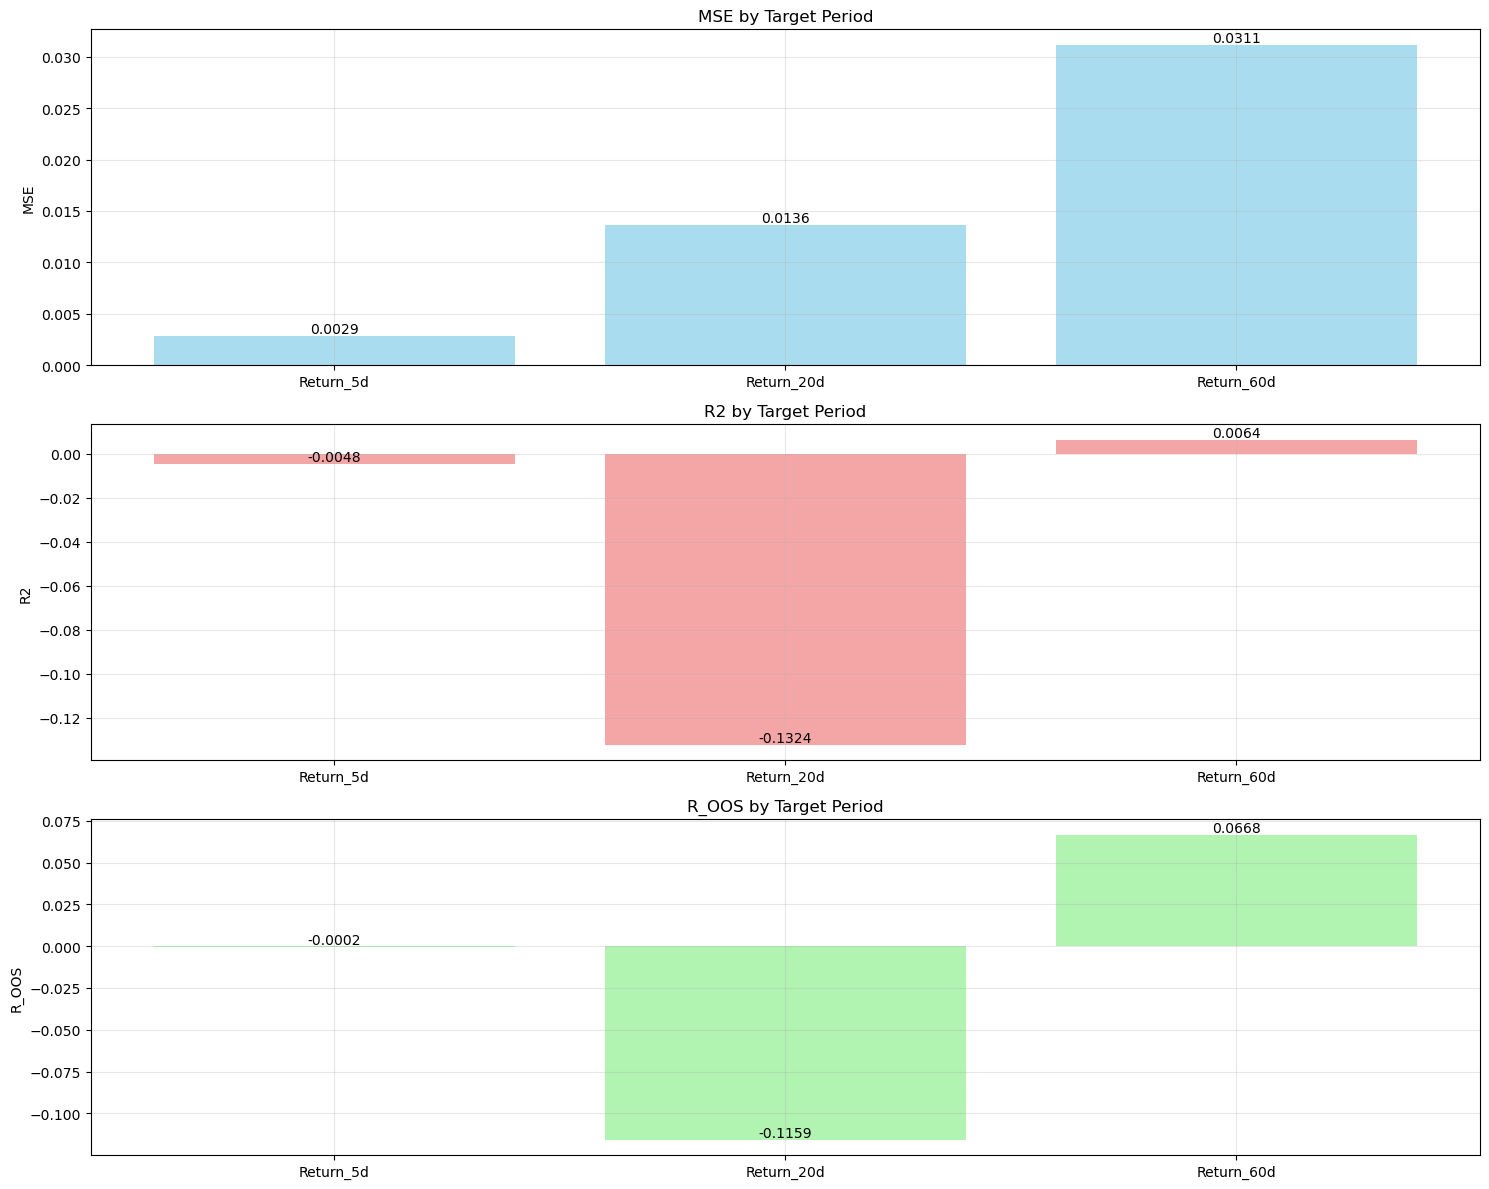

In [61]:
results = {}
models = {}
targets = ['Return_5d', 'Return_20d', 'Return_60d']

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth' : [1 ,3, 5, 10],
    'max_leaves' : [0, 5, 10 , 50],
    'learning_rate' : [0.1, 0.2, 0.5],
}


for target in targets:
    X_train = train_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']]
    y_train = train_df[target]
    X_test = test_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']]
    y_test = test_df[target]

    model = xgb.XGBRegressor(random_state=42)

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_


    model_name = f'model_{target.lower()}'
    models[model_name] = best_model

    model_filename = f'xgb_opt_{target.lower()}_model.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Model saved as {model_filename}")

    y_pred = best_model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r_oos = calculate_roos(y_test, y_pred)

    results[target] = {'MSE': mse, 'R2': r2, 'R_OOS': r_oos}


results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

metrics = ['MSE', 'R2', 'R_OOS']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, metric in enumerate(metrics):
    ax = axes[i]  
    
    values = [results[target][metric] for target in targets]
    bars = ax.bar(targets, values, color=colors[i], alpha=0.7)
    ax.set_title(f'{metric} by Target Period')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

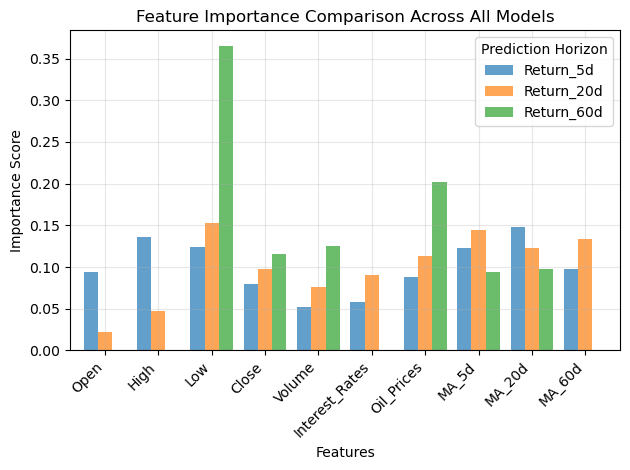

In [62]:
# Get feature names
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']

# Create a DataFrame to store feature importances for all models
feature_importance_comparison = pd.DataFrame(index=features)

# Get feature importances for each model
for target in targets:
    model_name = f'model_{target.lower()}'
    if model_name in models:
        importances = models[model_name].feature_importances_
        feature_importance_comparison[target] = importances

# Create the plot
plt.figure(figsize=(12, 8))
feature_importance_comparison.plot(kind='bar', width=0.8, alpha=0.7)
plt.title('Feature Importance Comparison Across All Models')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.legend(title='Prediction Horizon')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Similar to the XGboost without Hyperparameter tuning, we get similar values. The Low still seems to be the most indicative variable. Oil prices seem to play an even higher role. Overall, the features importances are consistent over the models.

### Portfolio Analysis

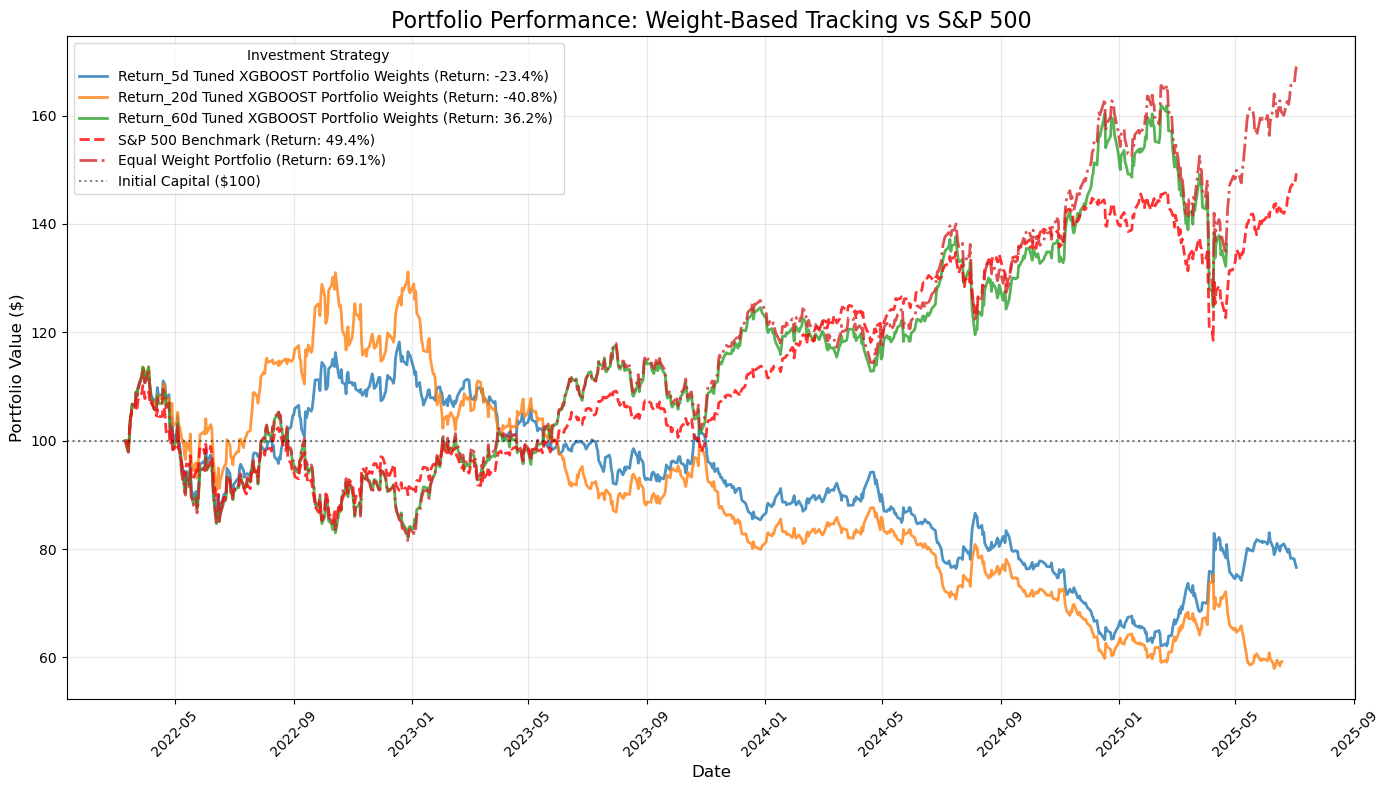

In [63]:
strategies = {}
initial_capital = 100

# Calculate S&P 500 benchmark for the test period
sp500_test = sp500[sp500['Date'] > split_date].copy().sort_values('Date')
sp500_start_price = sp500_test['Close'].iloc[0]
sp500_test['Normalized_Value'] = (sp500_test['Close'] / sp500_start_price) * initial_capital

# Implement trading strategies
plt.figure(figsize=(14, 8))

for target in targets:
    strategy_result = trade(models, test_df, initial_capital=initial_capital, target=target)
    
    if strategy_result is not None:
        strategies[target] = strategy_result
        
        final_value = strategy_result['final_value']
        total_return = (final_value / initial_capital - 1) * 100
        
        portfolio_df = strategy_result['portfolio_df']
        plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], 
                 label=f'{target} Tuned XGBOOST Portfolio Weights (Return: {total_return:.1f}%)', 
                 linewidth=2, alpha=0.8)

sp500_total_return = (sp500_test['Normalized_Value'].iloc[-1] / initial_capital - 1) * 100

plt.plot(sp500_test['Date'], sp500_test['Normalized_Value'], 
         label=f'S&P 500 Benchmark (Return: {sp500_total_return:.1f}%)', 
         color='red', linestyle='--', linewidth=2, alpha=0.8)


strategy_start_date = test_df['Date'].min()
strategy_end_date = test_df['Date'].max()

prices_test = prices.reset_index()
prices_test = prices_test[
    (prices_test['Date'] >= strategy_start_date) & 
    (prices_test['Date'] <= strategy_end_date)
].copy().sort_values('Date')

asset_cols = [c for c in prices_test.columns if c not in ['Date', 'sp500']]

equal_weights = np.ones(len(asset_cols)) / len(asset_cols)

asset_returns = prices_test[asset_cols].pct_change().fillna(0)
equal_curve = initial_capital * (1 + (asset_returns @ equal_weights)).cumprod()

# Plot + Return
equal_total_return = (equal_curve.iloc[-1] / initial_capital - 1) * 100
plt.plot(prices_test['Date'], equal_curve,
         label=f'Equal Weight Portfolio (Return: {equal_total_return:.1f}%)',
         linestyle='-.', linewidth=2, alpha=0.8)

# Add initial capital reference line
plt.axhline(y=initial_capital, color='black', linestyle=':', alpha=0.5, 
           label='Initial Capital ($100)')

plt.title('Portfolio Performance: Weight-Based Tracking vs S&P 500', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(title='Investment Strategy', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This graph seemingly represents the inverse of our initial not tuned model. The only model which yields positive results seems to be the 60 day. With over 36 percent gain over 3 years, it still underperfroms the S&P500.

### RANDOM FOREST

Model saved as rf_return_5d_model.pkl
Model saved as rf_return_20d_model.pkl
Model saved as rf_return_60d_model.pkl


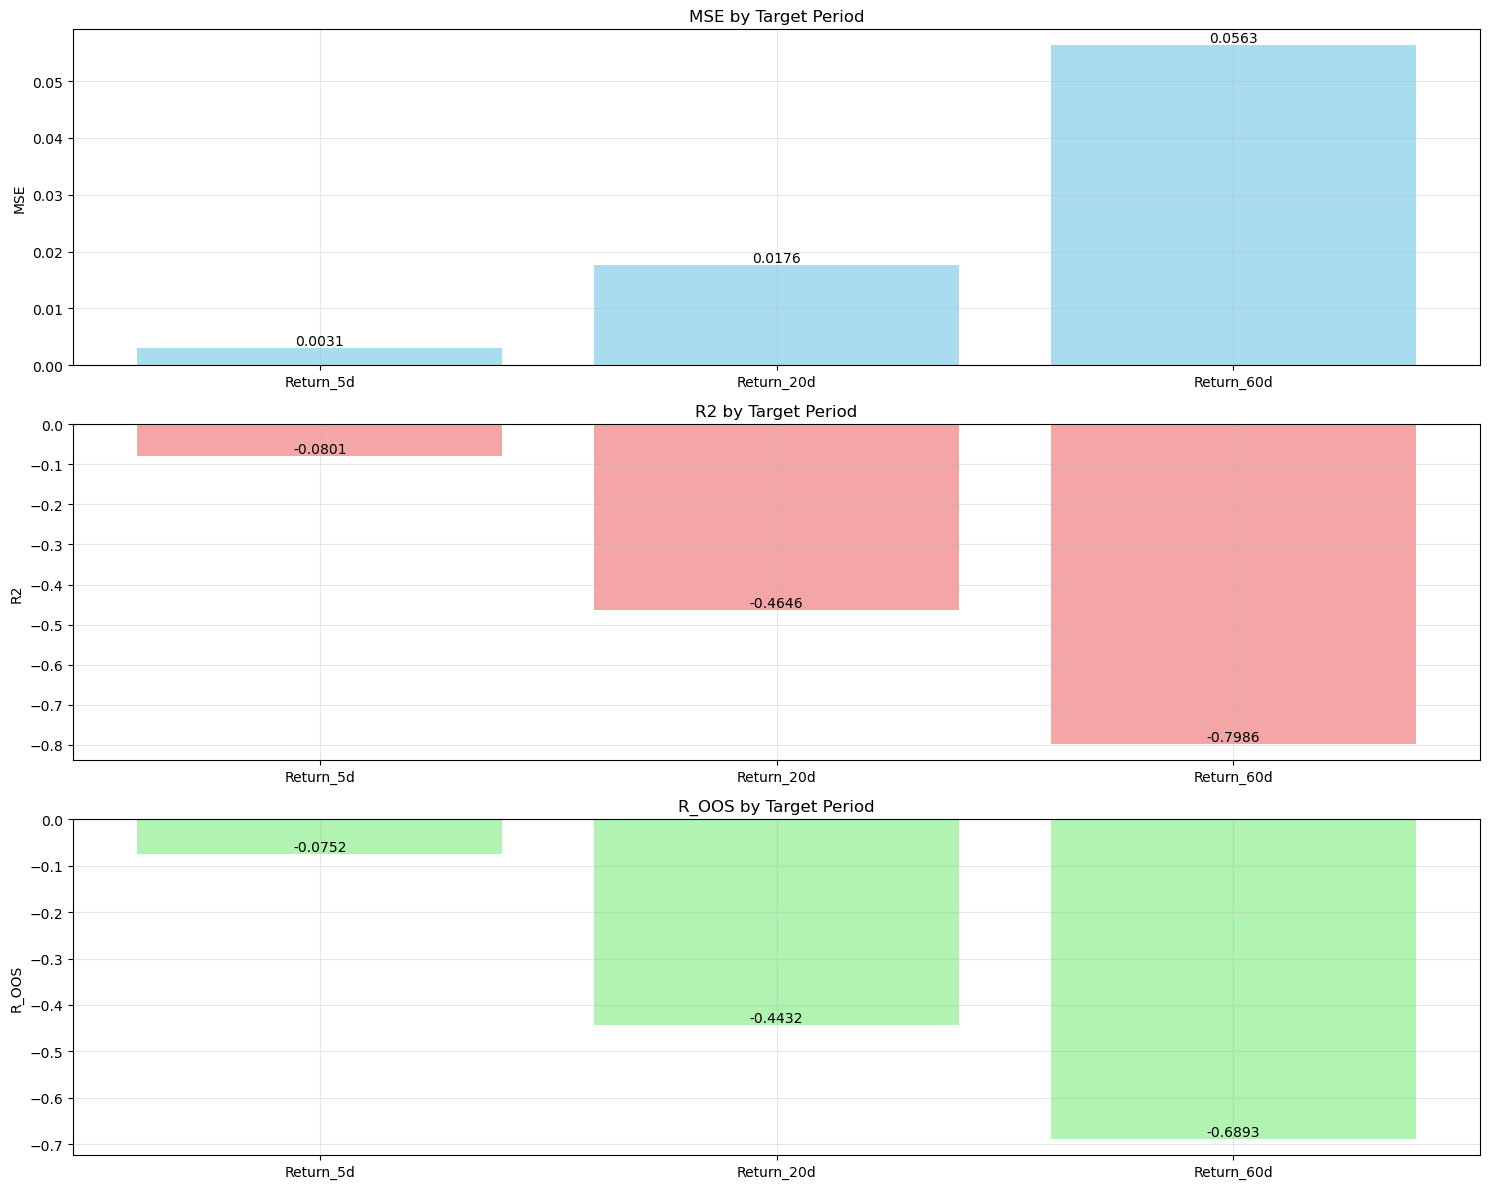

In [64]:
results = {}
models = {}
targets = ['Return_5d', 'Return_20d', 'Return_60d']

for target in targets:
    X_train = train_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']]
    y_train = train_df[target]
    X_test = test_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']]
    y_test = test_df[target]

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    model_name = f'model_{target.lower()}'
    models[model_name] = model

    model_filename = f'rf_{target.lower()}_model.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved as {model_filename}")

    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r_oos = calculate_roos(y_test, y_pred)

    results[target] = {'MSE': mse, 'R2': r2, 'R_OOS': r_oos}


results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

metrics = ['MSE', 'R2', 'R_OOS']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, metric in enumerate(metrics):
    ax = axes[i]  
    
    values = [results[target][metric] for target in targets]
    bars = ax.bar(targets, values, color=colors[i], alpha=0.7)
    ax.set_title(f'{metric} by Target Period')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

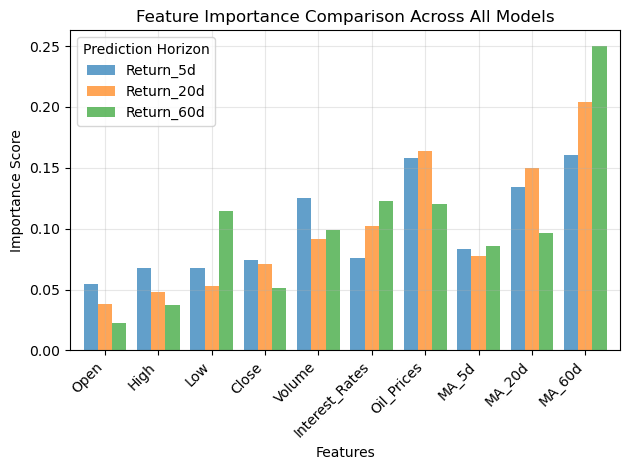

In [65]:
# Get feature names
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']

# Create a DataFrame to store feature importances for all models
feature_importance_comparison = pd.DataFrame(index=features)

# Get feature importances for each model
for target in targets:
    model_name = f'model_{target.lower()}'
    if model_name in models:
        importances = models[model_name].feature_importances_
        feature_importance_comparison[target] = importances

# Create the plot
plt.figure(figsize=(12, 8))
feature_importance_comparison.plot(kind='bar', width=0.8, alpha=0.7)
plt.title('Feature Importance Comparison Across All Models')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.legend(title='Prediction Horizon')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In the Ranodm Forest, we are already getting slightly different results regarding the Feature Importance. Unlike the XGBoost the most indicative features seem to be the Moving Averages, while the 60 day moving average seems to be the most indicative. Again Oil prices and interest rates seme to show predictive power in this model.

### Portfolio Analysis

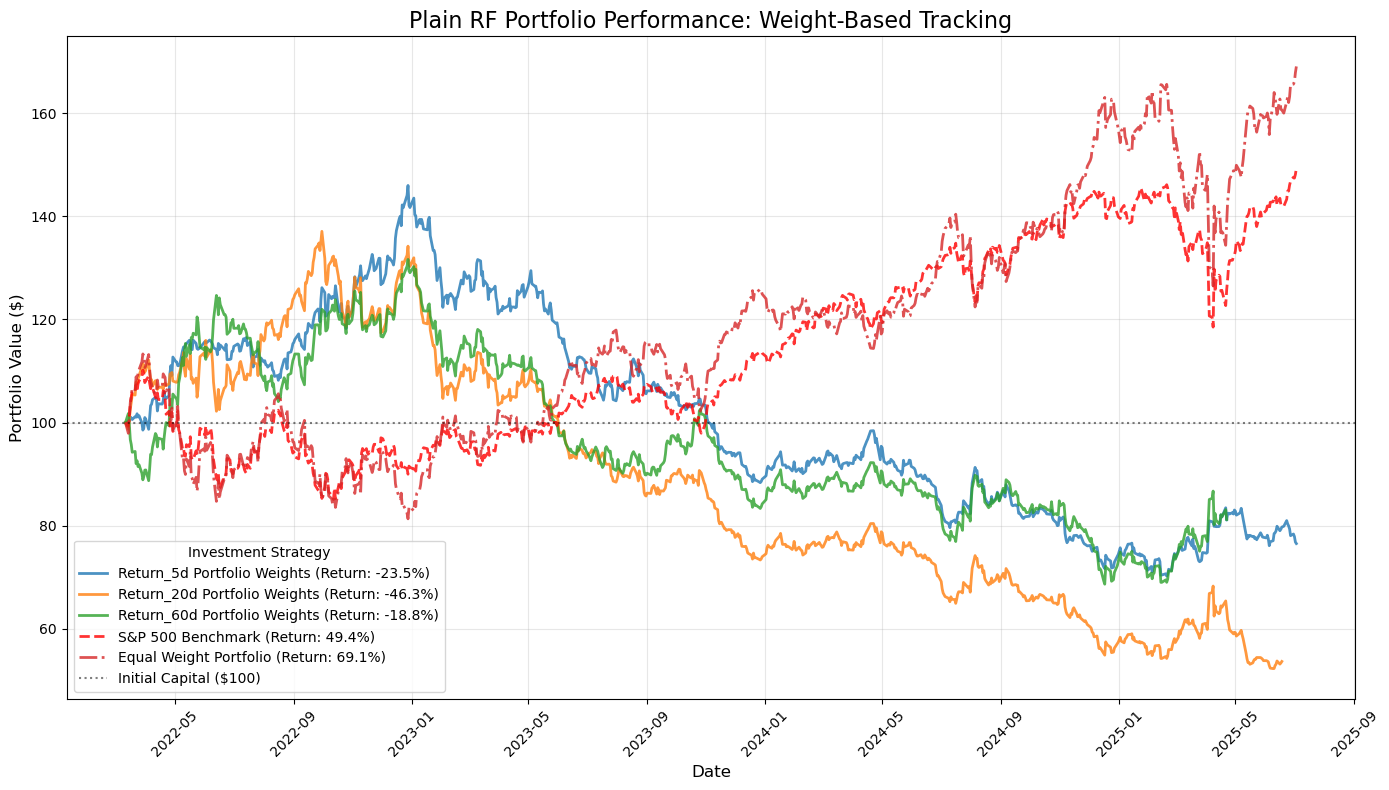

In [66]:
strategies = {}
initial_capital = 100

# Calculate S&P 500 benchmark for the test period
sp500_test = sp500[sp500['Date'] > split_date].copy().sort_values('Date')
sp500_start_price = sp500_test['Close'].iloc[0]
sp500_test['Normalized_Value'] = (sp500_test['Close'] / sp500_start_price) * initial_capital

# Implement trading strategies
plt.figure(figsize=(14, 8))

for target in targets:
    strategy_result = trade(models, test_df, initial_capital=initial_capital, target=target)
    
    if strategy_result is not None:
        strategies[target] = strategy_result
        
        final_value = strategy_result['final_value']
        total_return = (final_value / initial_capital - 1) * 100
        
        portfolio_df = strategy_result['portfolio_df']
        plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], 
                 label=f'{target} Portfolio Weights (Return: {total_return:.1f}%)', 
                 linewidth=2, alpha=0.8)

sp500_total_return = (sp500_test['Normalized_Value'].iloc[-1] / initial_capital - 1) * 100

plt.plot(sp500_test['Date'], sp500_test['Normalized_Value'], 
         label=f'S&P 500 Benchmark (Return: {sp500_total_return:.1f}%)', 
         color='red', linestyle='--', linewidth=2, alpha=0.8)


strategy_start_date = test_df['Date'].min()
strategy_end_date = test_df['Date'].max()

prices_test = prices.reset_index()
prices_test = prices_test[
    (prices_test['Date'] >= strategy_start_date) & 
    (prices_test['Date'] <= strategy_end_date)
].copy().sort_values('Date')

asset_cols = [c for c in prices_test.columns if c not in ['Date', 'sp500']]

equal_weights = np.ones(len(asset_cols)) / len(asset_cols)

asset_returns = prices_test[asset_cols].pct_change().fillna(0)
equal_curve = initial_capital * (1 + (asset_returns @ equal_weights)).cumprod()

# Plot + Return
equal_total_return = (equal_curve.iloc[-1] / initial_capital - 1) * 100
plt.plot(prices_test['Date'], equal_curve,
         label=f'Equal Weight Portfolio (Return: {equal_total_return:.1f}%)',
         linestyle='-.', linewidth=2, alpha=0.8)

# Add initial capital reference line
plt.axhline(y=initial_capital, color='black', linestyle=':', alpha=0.5, 
           label='Initial Capital ($100)')

plt.title('Plain RF Portfolio Performance: Weight-Based Tracking', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(title='Investment Strategy', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

All our portfolio strategies yielded negative returns over the past 3 years and show a similar trends.

### Hyperparameter Tuning

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Model saved as rf_opt_return_5d_model.pkl
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Model saved as rf_opt_return_20d_model.pkl
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Model saved as rf_opt_return_60d_model.pkl


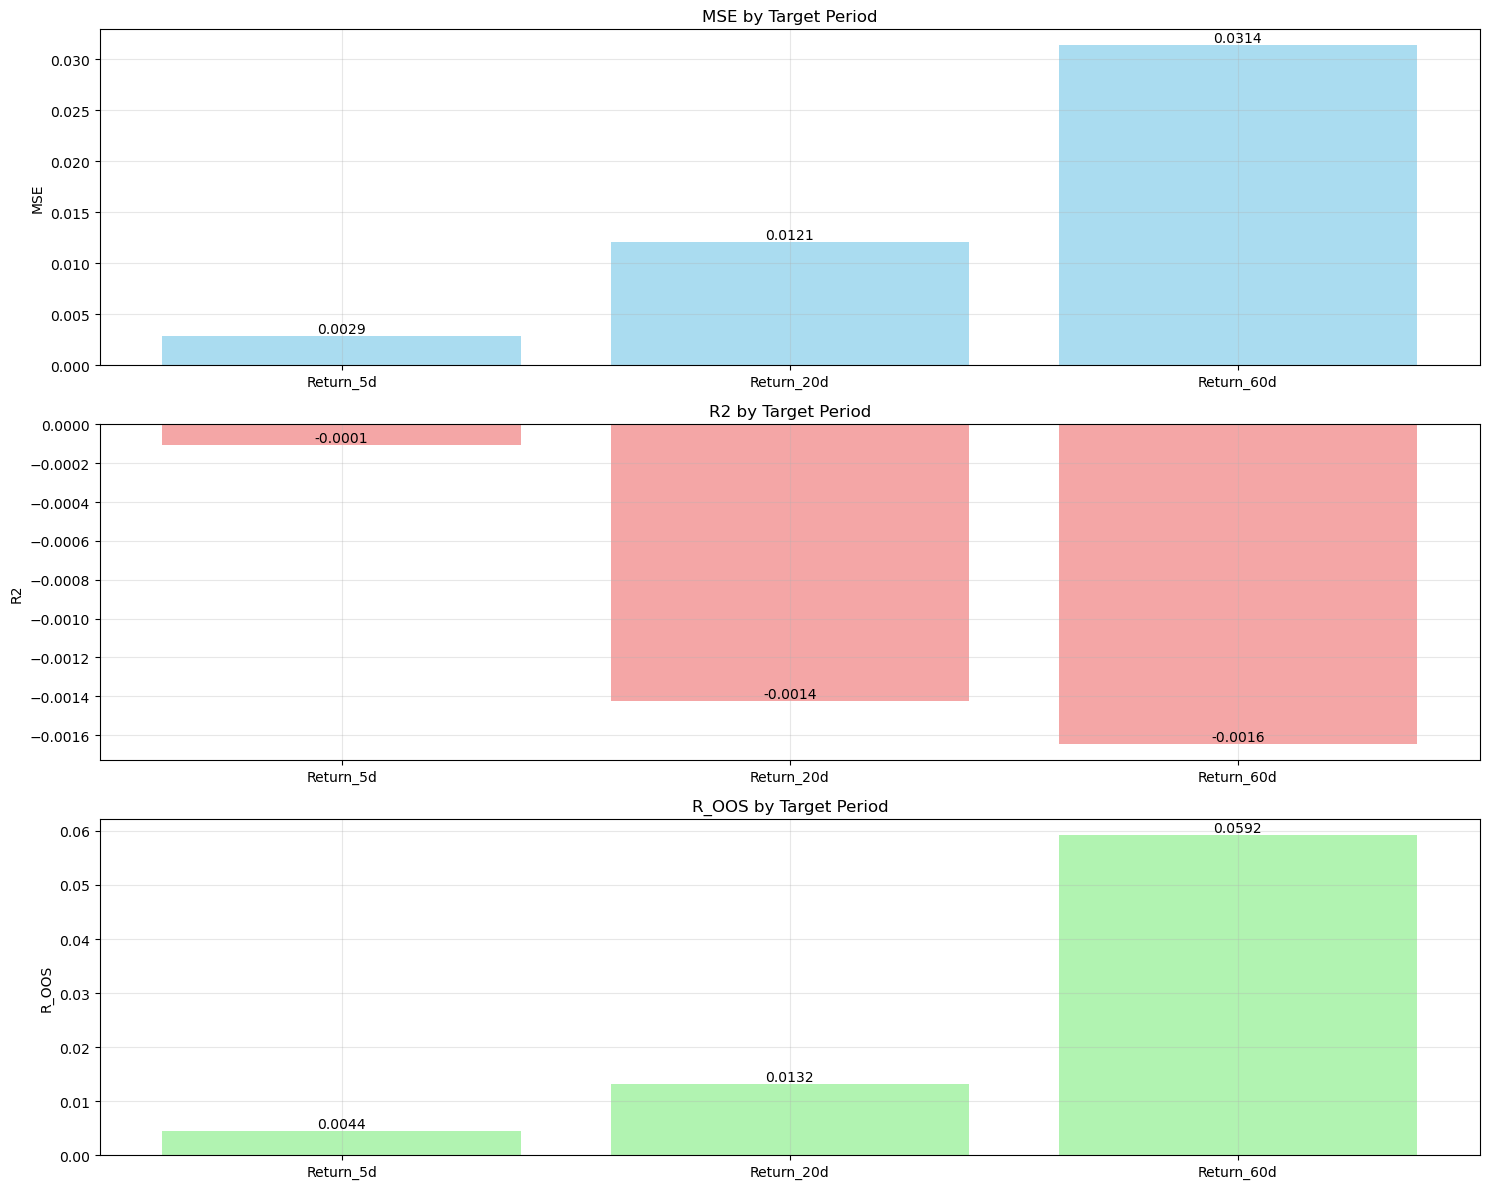

In [67]:
results = {}
models = {}
targets = ['Return_5d', 'Return_20d', 'Return_60d']

param_grid = {
    'n_estimators': [50, 100, 300, 500],
    'max_depth' : [1, 10, 50, 100],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 5, 10],
    'max_features' : ['auto', 'sqrt', 'log2']
}


for target in targets:
    X_train = train_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']]
    y_train = train_df[target]
    X_test = test_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']]
    y_test = test_df[target]

    model = RandomForestRegressor(random_state=42)

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_


    model_name = f'model_{target.lower()}'
    models[model_name] = best_model

    model_filename = f'rf_opt_{target.lower()}_model.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Model saved as {model_filename}")

    y_pred = best_model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r_oos = calculate_roos(y_test, y_pred)

    results[target] = {'MSE': mse, 'R2': r2, 'R_OOS': r_oos}


results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

metrics = ['MSE', 'R2', 'R_OOS']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, metric in enumerate(metrics):
    ax = axes[i]  
    
    values = [results[target][metric] for target in targets]
    bars = ax.bar(targets, values, color=colors[i], alpha=0.7)
    ax.set_title(f'{metric} by Target Period')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

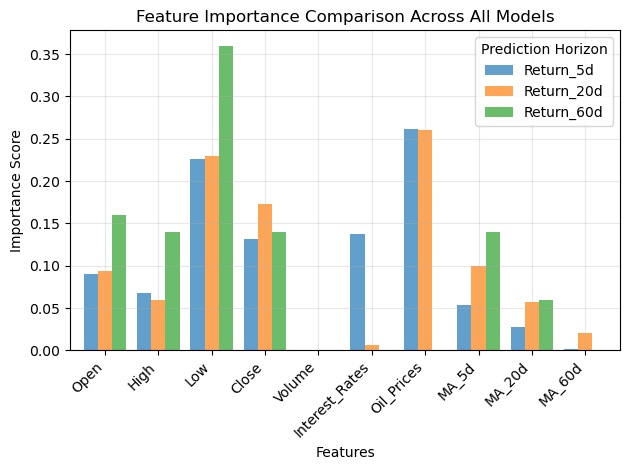

In [68]:
# Get feature names
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']

# Create a DataFrame to store feature importances for all models
feature_importance_comparison = pd.DataFrame(index=features)

# Get feature importances for each model
for target in targets:
    model_name = f'model_{target.lower()}'
    if model_name in models:
        importances = models[model_name].feature_importances_
        feature_importance_comparison[target] = importances

# Create the plot
plt.figure(figsize=(12, 8))
feature_importance_comparison.plot(kind='bar', width=0.8, alpha=0.7)
plt.title('Feature Importance Comparison Across All Models')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.legend(title='Prediction Horizon')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The Hypertuninh shows us a similar result to the XGboost. Interestingly, the Moving Average lost importance and the Low Price returned to be the most indicative feature.

### Portfolio Analysis

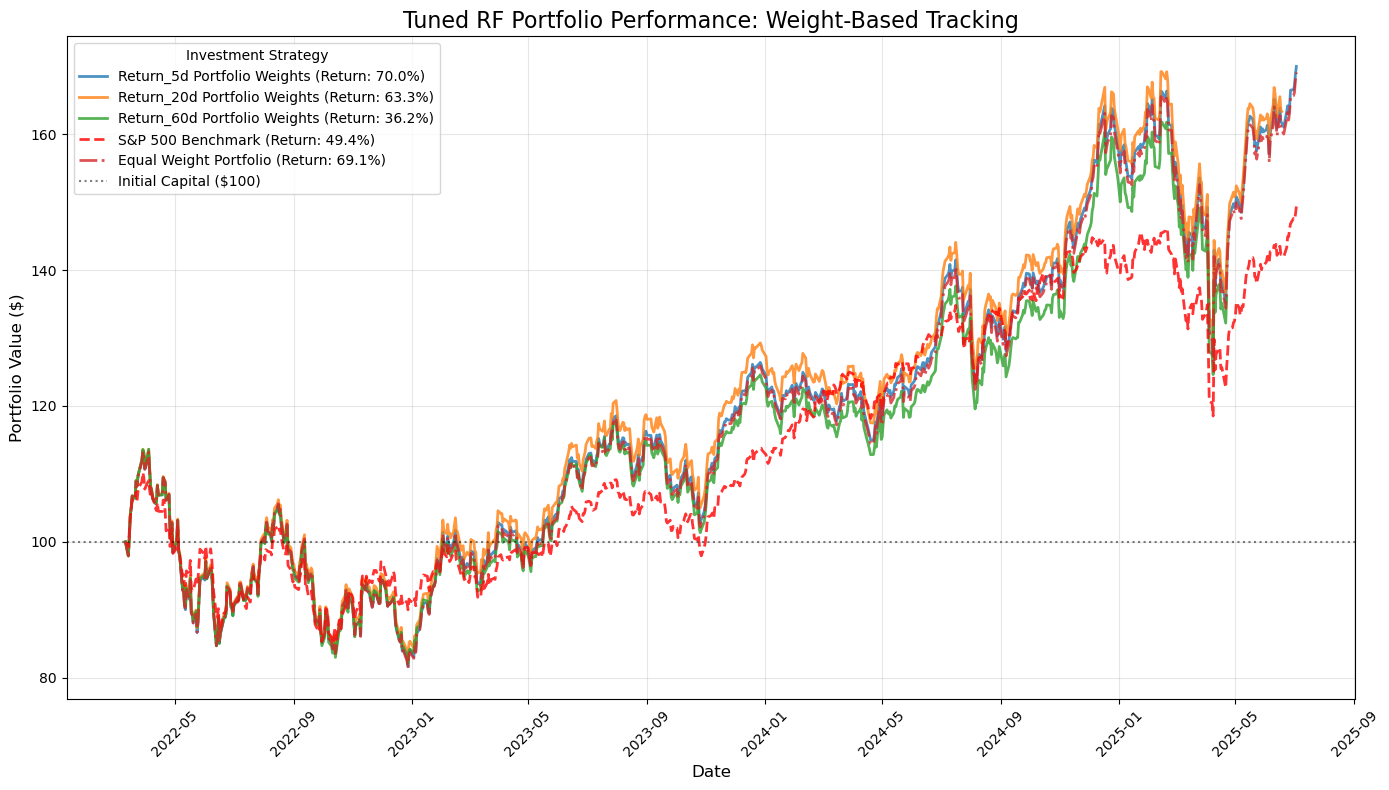

In [69]:
strategies = {}
initial_capital = 100

# Calculate S&P 500 benchmark for the test period
sp500_test = sp500[sp500['Date'] > split_date].copy().sort_values('Date')
sp500_start_price = sp500_test['Close'].iloc[0]
sp500_test['Normalized_Value'] = (sp500_test['Close'] / sp500_start_price) * initial_capital

# Implement trading strategies
plt.figure(figsize=(14, 8))

for target in targets:
    strategy_result = trade(models, test_df, initial_capital=initial_capital, target=target)
    
    if strategy_result is not None:
        strategies[target] = strategy_result
        
        final_value = strategy_result['final_value']
        total_return = (final_value / initial_capital - 1) * 100
        
        portfolio_df = strategy_result['portfolio_df']
        plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], 
                 label=f'{target} Portfolio Weights (Return: {total_return:.1f}%)', 
                 linewidth=2, alpha=0.8)

sp500_total_return = (sp500_test['Normalized_Value'].iloc[-1] / initial_capital - 1) * 100

plt.plot(sp500_test['Date'], sp500_test['Normalized_Value'], 
         label=f'S&P 500 Benchmark (Return: {sp500_total_return:.1f}%)', 
         color='red', linestyle='--', linewidth=2, alpha=0.8)


strategy_start_date = test_df['Date'].min()
strategy_end_date = test_df['Date'].max()

prices_test = prices.reset_index()
prices_test = prices_test[
    (prices_test['Date'] >= strategy_start_date) & 
    (prices_test['Date'] <= strategy_end_date)
].copy().sort_values('Date')


asset_cols = [c for c in prices_test.columns if c not in ['Date', 'sp500']]


equal_weights = np.ones(len(asset_cols)) / len(asset_cols)

asset_returns = prices_test[asset_cols].pct_change().fillna(0)
equal_curve = initial_capital * (1 + (asset_returns @ equal_weights)).cumprod()

# Plot + Return
equal_total_return = (equal_curve.iloc[-1] / initial_capital - 1) * 100
plt.plot(prices_test['Date'], equal_curve,
         label=f'Equal Weight Portfolio (Return: {equal_total_return:.1f}%)',
         linestyle='-.', linewidth=2, alpha=0.8)

# Add initial capital reference line
plt.axhline(y=initial_capital, color='black', linestyle=':', alpha=0.5, 
           label='Initial Capital ($100)')

plt.title('Tuned RF Portfolio Performance: Weight-Based Tracking', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(title='Investment Strategy', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finally, we seem to have great results outperforming the S&P500 over the past 3 years. The best model seems to be the 5 day return portfolio. The further we predict into the future the lower our returns are. Only the 60 day seems to perform worse than the S&P. 

In [70]:
strategies['Return_60d']

{'portfolio_df':           Date  Portfolio_Value
 0   2022-03-11       100.000000
 1   2022-03-14        97.917027
 2   2022-03-15       100.580881
 3   2022-03-16       103.914664
 4   2022-03-17       105.039466
 ..         ...              ...
 776 2025-04-15       137.483962
 777 2025-04-16       134.265265
 778 2025-04-17       135.125459
 779 2025-04-21       132.189612
 780 2025-04-22       136.189890
 
 [781 rows x 2 columns],
 'portfolio_values': 2022-03-11    100.000000
 2022-03-14     97.917027
 2022-03-15    100.580881
 2022-03-16    103.914664
 2022-03-17    105.039466
                  ...    
 2025-04-15    137.483962
 2025-04-16    134.265265
 2025-04-17    135.125459
 2025-04-21    132.189612
 2025-04-22    136.189890
 Length: 781, dtype: float64,
 'final_value': np.float64(136.18989016653046)}

In [71]:
test_df

Date Ticker       Close        High         Low        Open  \
22472 2022-03-11      T   14.291995   14.606308   14.267342   14.544678   
25801 2022-03-11   TSLA  265.116669  281.266663  264.589996  280.066681   
12485 2022-03-11   GOOG  129.588684  133.287872  129.410900  133.088734   
19143 2022-03-11    MGM   40.099712   41.489355   40.049726   41.189433   
5827  2022-03-11   AMZN  145.524506  149.675003  145.369003  149.574493   
...          ...    ...         ...         ...         ...         ...   
3328  2025-07-03   AAPL  213.307922  214.406666  211.569889  211.909500   
13315 2025-07-03   GOOG  180.388779  180.608583  178.030885  179.659435   
19973 2025-07-03    MGM   37.590000   38.029999   37.509998   37.860001   
16644 2025-07-03    IBM  290.009216  290.356872  285.966542  286.006282   
26631 2025-07-03   TSLA  315.350006  318.450012  312.760010  317.989990   

         Volume  Return_5d  Return_20d  Return_60d       MA_5d      MA_20d  \
22472  72142244   0.001293    0.040966    0.224359   14.324042   14.591515   
25801  67037100   0.138354    0.289357   -0.098938  274.773328  282.083163   
12485  26600000   0.048484    0.027093   -0.101521  129.268680  131.664313   
19143   3744100   0.051359   -0.022688   -0.115183   39.266728   42.644142   
5827   68900000   0.108064    0.061405   -0.154782  141.017703  149.294101   
...         ...        ...         ...         ...         ...         ...   
3328   34955800  -0.011192   -0.052306    0.192783  207.776193  201.729056   
13315  13287400   0.004209    0.052063    0.354630  178.416537  174.994897   
19973   2311200   0.009045   -0.048949   -0.028199   36.181999   33.936000   
16644   1853300  -0.028702   -0.143576   -0.035203  289.105328  281.801701   
26631  58042300  -0.005835   -0.040336    0.405454  314.600000  319.526498   

           MA_60d  Interest_Rates  Oil_Prices  
22472   15.119324            0.20      109.31  
25801  314.395330            0.20      109.31  
12485  136.555034            0.20      109.31  
19143   43.430722            0.20      109.31  
5827   156.167166            0.20      109.31  
...           ...             ...         ...  
3328   201.913323            4.33       68.13  
13315  166.636863            4.33       68.13  
19973   32.273500            4.33       68.13  
16644  258.458273            4.33       68.13  
26631  305.326500            4.33       68.13  

[6648 rows x 15 columns]

### AMAZON CHRONOS-BOLT-BASE

In [72]:
# Initialize Chronos model
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu", 
    torch_dtype=torch.bfloat16,
)

results = {}
models = {}
targets = ['Return_5d', 'Return_20d', 'Return_60d']

for target in targets:
    # Prepare data for time series forecasting
    chronos_results = {}
    
    for ticker in train_df['Ticker'].unique():
        ticker_train = train_df[train_df['Ticker'] == ticker].sort_values('Date')
        ticker_test = test_df[test_df['Ticker'] == ticker].sort_values('Date')
        
        if len(ticker_train) > 60 and len(ticker_test) > 0:
            # Use rolling forecasts with max 64-day windows
            context = torch.tensor(ticker_train[target].values[-60:])
            
            all_predictions = []
            remaining_length = len(ticker_test)
            
            # Make predictions in chunks of 64 or less
            while remaining_length > 0:
                current_forecast_length = min(64, remaining_length)
                
                forecast = pipeline.predict(context, prediction_length=current_forecast_length)
                predictions = forecast[0].median(dim=0).values.numpy()
                
                all_predictions.extend(predictions)
                remaining_length -= current_forecast_length
                
                # Update context with new predictions (rolling forecast)
                if remaining_length > 0:
                    # Use last part of context + new predictions as new context
                    new_context = torch.cat([
                        context[current_forecast_length:],
                        torch.tensor(predictions)
                    ])
                    context = new_context[-60:]  # Keep last 60 observations
            
            chronos_results[ticker] = {
                'predictions': np.array(all_predictions[:len(ticker_test)]),
                'actual': ticker_test[target].values
            }
    
    # Calculate metrics (same as before)
    all_predictions = []
    all_actuals = []
    
    for ticker, results_dict in chronos_results.items():
        all_predictions.extend(results_dict['predictions'])
        all_actuals.extend(results_dict['actual'])
    
    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)
    
    # Calculate metrics
    mse = mean_squared_error(all_actuals, all_predictions)
    r2 = r2_score(all_actuals, all_predictions)
    r_oos = calculate_roos(all_actuals, all_predictions)
    
    results[target] = {'MSE': mse, 'R2': r2, 'R_OOS': r_oos}
    models[f'chronos_{target.lower()}'] = chronos_results

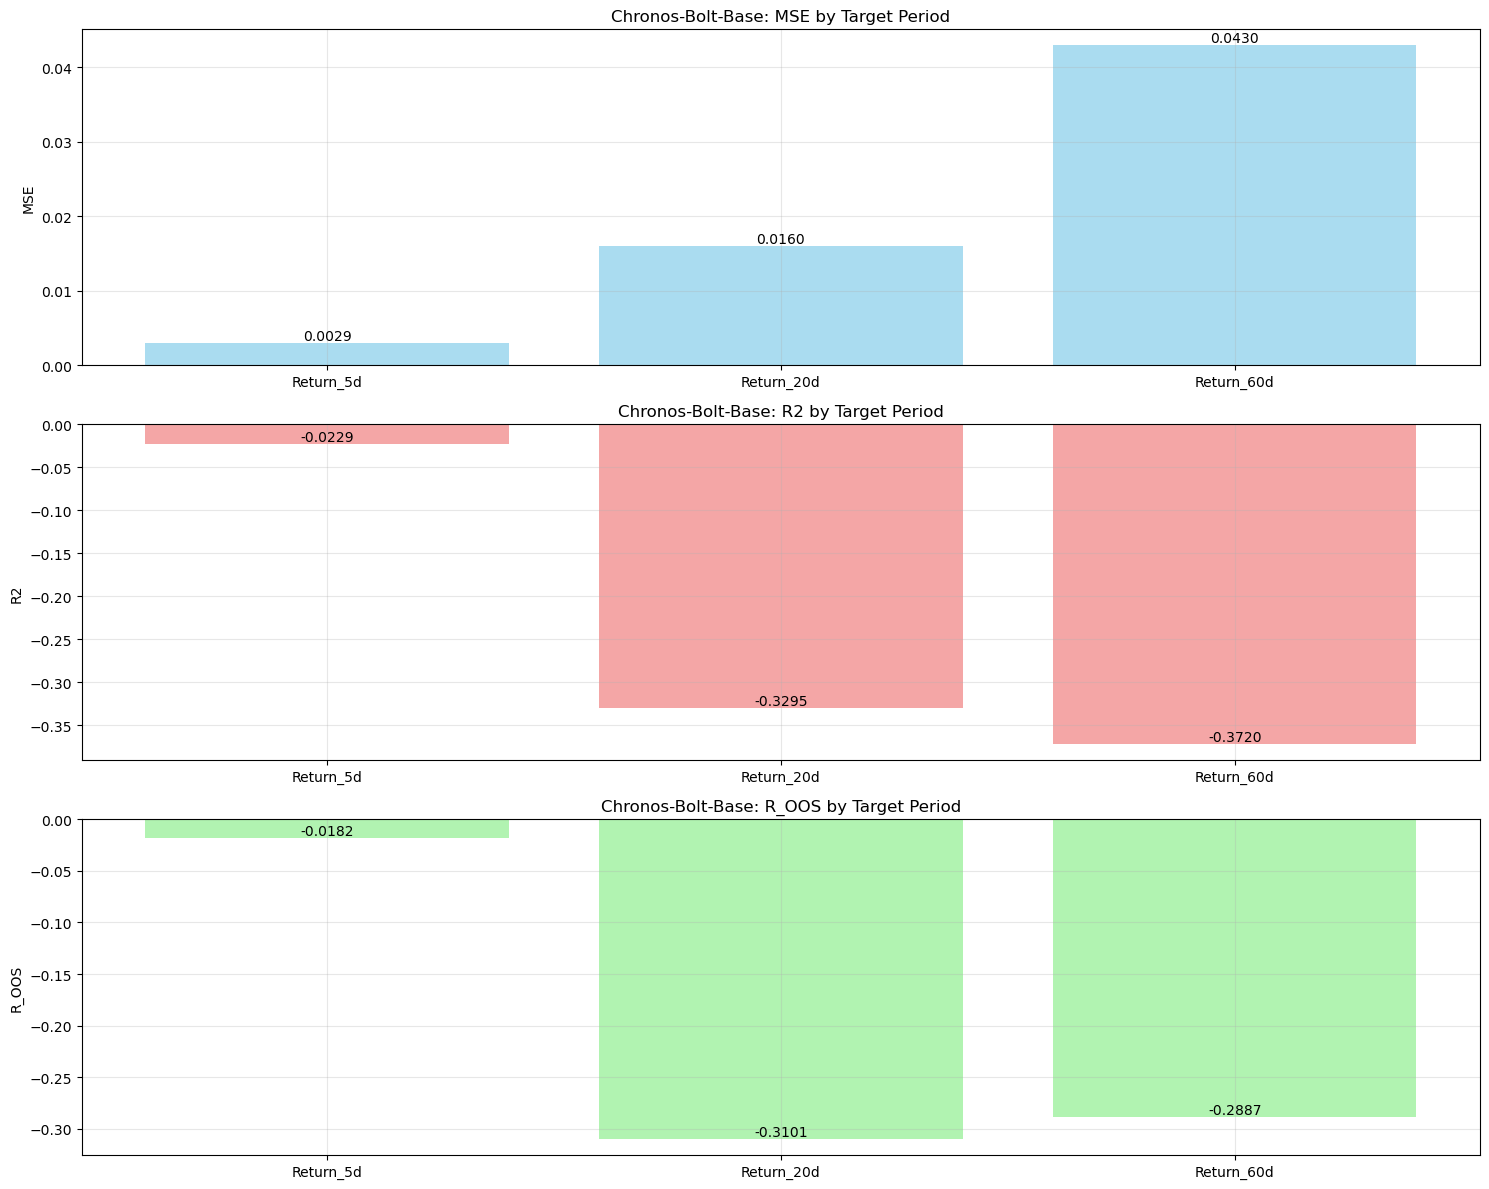

In [73]:
# Display results
results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(3, 1, figsize=(15, 12))
metrics = ['MSE', 'R2', 'R_OOS']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = [results[target][metric] for target in targets]
    bars = ax.bar(targets, values, color=colors[i], alpha=0.7)
    ax.set_title(f'Chronos-Bolt-Base: {metric} by Target Period')
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)
    
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Portfolio Analysis

In [74]:
def trade_chronos(chronos_models, test_df, initial_capital=100, target='Return_5d'):
    model_name = f'chronos_{target.lower()}'
    chronos_results = chronos_models[model_name]
    
    # Determine holding period
    if target == 'Return_5d':
        holding_period = 5
    elif target == 'Return_20d':
        holding_period = 20
    else:  # Return_60d
        holding_period = 60
    
    # Get all unique tickers and dates
    tickers = test_df['Ticker'].unique()
    all_dates = sorted(test_df['Date'].unique())
    
    # Initialize portfolio tracking
    portfolio_values = []
    portfolio_dates = []
    
    current_portfolio_value = initial_capital
    portfolio_values.append(current_portfolio_value)
    portfolio_dates.append(all_dates[0])
    
    i = 0
    while i < len(all_dates) - holding_period:
        current_date = all_dates[i]
        
        # Get data for current date for all stocks
        current_data = test_df[test_df['Date'] == current_date]
        
        if len(current_data) == 0:
            i += 1
            continue
        
        # Use pre-computed Chronos predictions
        signals = {}
        prices = {}
        stock_positions = {}
        
        for ticker in tickers:
            ticker_data = current_data[current_data['Ticker'] == ticker]
            if len(ticker_data) > 0 and ticker in chronos_results:
                # Find the prediction for this date
                ticker_test_data = test_df[test_df['Ticker'] == ticker].sort_values('Date')
                try:
                    # Find the index of current date in test data
                    date_mask = ticker_test_data['Date'] == current_date
                    if date_mask.any():
                        pred_index = ticker_test_data[date_mask].index[0] - ticker_test_data.index[0]
                        
                        if pred_index < len(chronos_results[ticker]['predictions']):
                            prediction = chronos_results[ticker]['predictions'][pred_index]
                            signal = 1 if prediction > 0 else -1
                            price = ticker_data['Close'].iloc[0]
                            
                            signals[ticker] = signal
                            prices[ticker] = price
                except:
                    continue
        
        # Calculate positions (only for stocks with valid signals)
        if len(signals) > 0:
            allocation_per_stock = current_portfolio_value / len(signals)
            
            for ticker in signals:
                shares = allocation_per_stock / prices[ticker]
                shares = shares * signals[ticker]
                
                stock_positions[ticker] = {
                    'shares': shares,
                    'entry_price': prices[ticker],
                    'entry_date': current_date,
                    'signal': signals[ticker]
                }
        
        # Calculate portfolio values during holding period
        for day_offset in range(1, holding_period + 1):
            if i + day_offset >= len(all_dates):
                break
                
            valuation_date = all_dates[i + day_offset]
            valuation_data = test_df[test_df['Date'] == valuation_date]
            
            portfolio_value = 0
            
            for ticker in stock_positions:
                ticker_valuation = valuation_data[valuation_data['Ticker'] == ticker]
                
                if len(ticker_valuation) > 0:
                    current_price = ticker_valuation['Close'].iloc[0]
                    position = stock_positions[ticker]
                    
                    if position['signal'] == 1:  # Long position
                        position_value = position['shares'] * current_price
                    else:  # Short position
                        entry_value = abs(position['shares']) * position['entry_price']
                        short_pnl = abs(position['shares']) * (position['entry_price'] - current_price)
                        position_value = entry_value + short_pnl
                    
                    portfolio_value += position_value
            
            if portfolio_value > 0:
                portfolio_values.append(portfolio_value)
                portfolio_dates.append(valuation_date)
        
        # Update for next period
        current_portfolio_value = portfolio_values[-1] if portfolio_values else initial_capital
        i += holding_period
    
    # Create results DataFrame
    portfolio_df = pd.DataFrame({
        'Date': portfolio_dates,
        'Portfolio_Value': portfolio_values
    })
    
    return {
        'portfolio_df': portfolio_df,
        'portfolio_values': pd.Series(portfolio_values, index=portfolio_dates),
        'final_value': portfolio_values[-1] if portfolio_values else initial_capital
    }


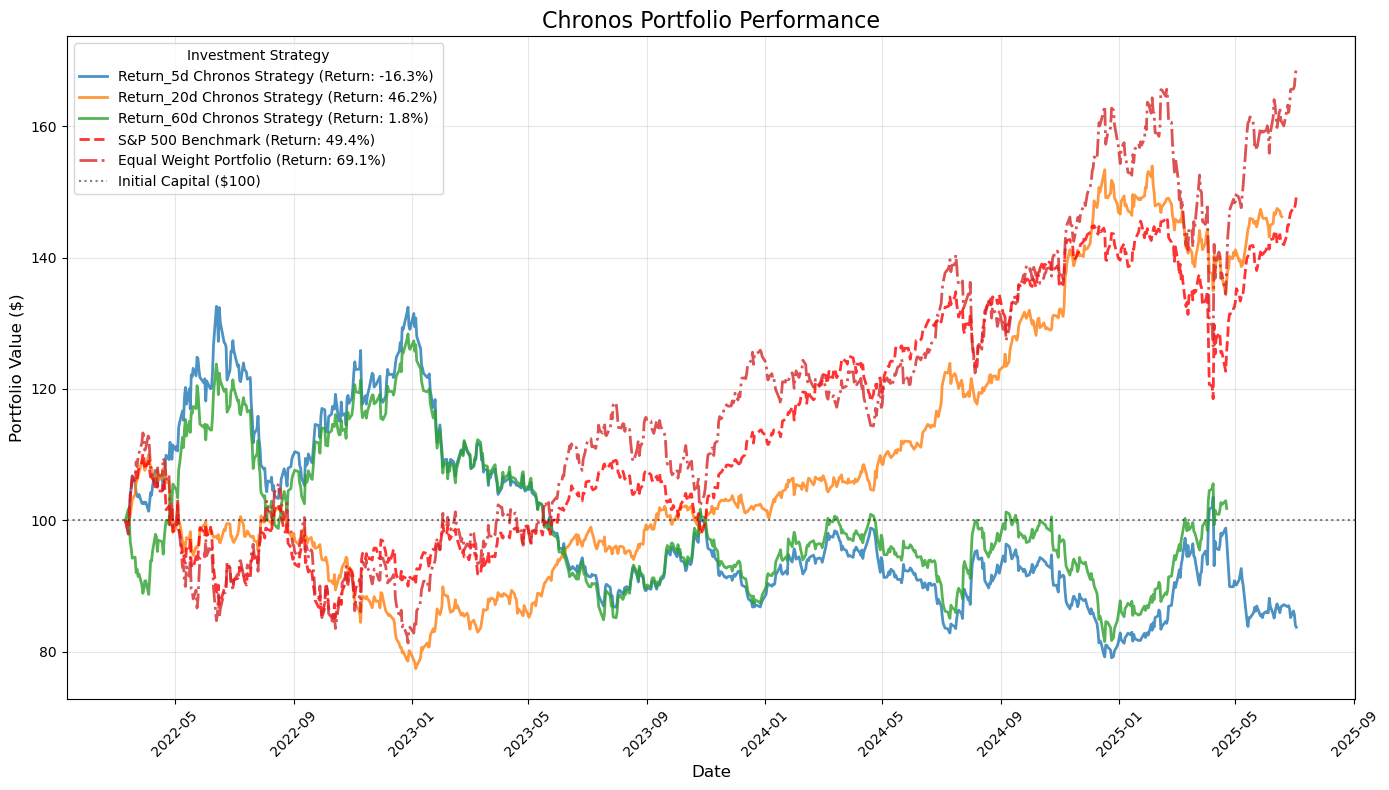

In [75]:
# Fixed Portfolio Analysis for Chronos
strategies = {}
initial_capital = 100

# Calculate S&P 500 benchmark for the test period
sp500_test = sp500[sp500['Date'] > split_date].copy().sort_values('Date')
sp500_start_price = sp500_test['Close'].iloc[0]
sp500_test['Normalized_Value'] = (sp500_test['Close'] / sp500_start_price) * initial_capital

# Implement trading strategies
plt.figure(figsize=(14, 8))

for target in targets:
    strategy_result = trade_chronos(models, test_df, initial_capital=initial_capital, target=target)
    
    if strategy_result is not None:
        strategies[target] = strategy_result
        
        final_value = strategy_result['final_value']
        total_return = (final_value / initial_capital - 1) * 100
        
        portfolio_df = strategy_result['portfolio_df']
        plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], 
                 label=f'{target} Chronos Strategy (Return: {total_return:.1f}%)', 
                 linewidth=2, alpha=0.8)

sp500_total_return = (sp500_test['Normalized_Value'].iloc[-1] / initial_capital - 1) * 100

plt.plot(sp500_test['Date'], sp500_test['Normalized_Value'], 
         label=f'S&P 500 Benchmark (Return: {sp500_total_return:.1f}%)', 
         color='red', linestyle='--', linewidth=2, alpha=0.8)

strategy_start_date = test_df['Date'].min()
strategy_end_date = test_df['Date'].max()

prices_test = prices.reset_index()
prices_test = prices_test[
    (prices_test['Date'] >= strategy_start_date) & 
    (prices_test['Date'] <= strategy_end_date)
].copy().sort_values('Date')


asset_cols = [c for c in prices_test.columns if c not in ['Date', 'sp500']]

equal_weights = np.ones(len(asset_cols)) / len(asset_cols)

asset_returns = prices_test[asset_cols].pct_change().fillna(0)
equal_curve = initial_capital * (1 + (asset_returns @ equal_weights)).cumprod()

# Plot + Return
equal_total_return = (equal_curve.iloc[-1] / initial_capital - 1) * 100
plt.plot(prices_test['Date'], equal_curve,
         label=f'Equal Weight Portfolio (Return: {equal_total_return:.1f}%)',
         linestyle='-.', linewidth=2, alpha=0.8)

# Add initial capital reference line
plt.axhline(y=initial_capital, color='black', linestyle=':', alpha=0.5, 
           label='Initial Capital ($100)')

plt.title('Chronos Portfolio Performance', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(title='Investment Strategy', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The Amazon Chronos Bolt Case visibly delivers the highest variability across our models. Here the 20 day portfolio performed best over the 3 different times. With almost 43 percent return over three years, it significally performs better than the 5 and 60 day portfolio. More importantly the 20 day model seems to capture the trend of the S&P500 quite well.

### Conclusions

It is difficult to compare our results to those of Gu et. al as the data used in the paper include over 900 features, why are not available in our dataset. However, we can agree with the findings that ML methods outperformed classic OLS in this context.

However, our findings do not agree with those of Jiang et al. The NN used in this notebook seemed to lack predictive power. Perhaps the missing convolutions, the added features of interest rates and oil prices, or the fact that the NN was not finetuned to this task prevent us from reaching the desired outcomes.

## Task 4

### Load in Best Model

In [76]:
import pickle

# Modell laden
with open("rf_opt_return_5d_model.pkl", "rb") as f:
    model = pickle.load(f)

In [77]:
model

RandomForestRegressor(max_depth=1, max_features='sqrt', min_samples_leaf=10,
                      n_estimators=500, random_state=42)

### Redefine Trading Function

Here we redefine the trading function to include transaction costs which will be useful for future parts of this task. We also set the holding period to 1 to allow for rebalancing of the portfolio on a daily basis.

In [78]:
def trade(model, test_df, initial_capital=100, target='Return_5d', trade_fees=0.0003):
    trade_fees = 1 - trade_fees
    model = model
    
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Interest_Rates', 'Oil_Prices', 'MA_5d', 'MA_20d', 'MA_60d']
    
    # Determine holding period
    if target == 'Return_5d':
        holding_period = 1
    
    # Get all unique tickers and dates
    tickers = test_df['Ticker'].unique()
    all_dates = sorted(test_df['Date'].unique())
    
    # Initialize portfolio tracking
    portfolio_values = []
    portfolio_dates = []
    
    # Equal initial weights across all stocks
    num_stocks = len(tickers)
    initial_weight_per_stock = initial_capital / num_stocks
    
    # Track positions for each stock
    stock_positions = {}  # {ticker: {'shares': shares, 'entry_price': price, 'entry_date': date}}
    
    current_portfolio_value = initial_capital
    portfolio_values.append(current_portfolio_value)
    portfolio_dates.append(all_dates[0])
    
    i = 0
    while i < len(all_dates) - holding_period:
        current_date = all_dates[i]
        
        # Get data for current date for all stocks
        current_data = test_df[test_df['Date'] == current_date]
        
        if len(current_data) == 0:
            i += 1
            continue
            
        # Make predictions for each stock
        signals = {}
        prices = {}
        
        for ticker in tickers:
            ticker_data = current_data[current_data['Ticker'] == ticker]
            if len(ticker_data) > 0:
                X = ticker_data[features]
                prediction = model.predict(X)[0]
                signal = 1 if prediction > 0 else -1
                price = ticker_data['Close'].iloc[0]
                
                signals[ticker] = signal
                prices[ticker] = price
        
        # Calculate number of shares for each stock (equal dollar allocation)
        allocation_per_stock = current_portfolio_value / num_stocks
        
        for ticker in tickers:
            if ticker in prices and ticker in signals:
                shares = allocation_per_stock / prices[ticker]
                # Adjust shares based on signal (long/short)
                shares = shares * signals[ticker]
                
                stock_positions[ticker] = {
                    'shares': shares,
                    'entry_price': prices[ticker],
                    'entry_date': current_date,
                    'signal': signals[ticker]
                }
        
        # Calculate portfolio values for each day during the holding period
        for day_offset in range(1, holding_period + 1):
            if i + day_offset >= len(all_dates):
                break
                
            valuation_date = all_dates[i + day_offset]
            valuation_data = test_df[test_df['Date'] == valuation_date]
            
            portfolio_value = 0
            
            for ticker in stock_positions:
                ticker_valuation = valuation_data[valuation_data['Ticker'] == ticker]
                
                if len(ticker_valuation) > 0:
                    current_price = ticker_valuation['Close'].iloc[0]
                    position = stock_positions[ticker]
                    
                    if position['signal'] == 1:  # Long position
                        position_value = position['shares'] * current_price
                    else:
                        entry_value = abs(position['shares']) * position['entry_price']
                        short_pnl = abs(position['shares']) * (position['entry_price'] - current_price)
                        position_value = entry_value + short_pnl
                    
                    portfolio_value += position_value
            
            if portfolio_value > 0:
                portfolio_values.append(portfolio_value)
                portfolio_dates.append(valuation_date)
        
        # Update current portfolio value and move to next period
        current_portfolio_value = portfolio_values[-1] * trade_fees if portfolio_values else initial_capital
        i += holding_period
    
    # Create results DataFrame
    portfolio_df = pd.DataFrame({
        'Date': portfolio_dates,
        'Portfolio_Value': portfolio_values
    })
    
    return {
        'portfolio_df': portfolio_df,
        'portfolio_values': pd.Series(portfolio_values, index=portfolio_dates),
        'final_value': portfolio_values[-1] if portfolio_values else initial_capital
    }

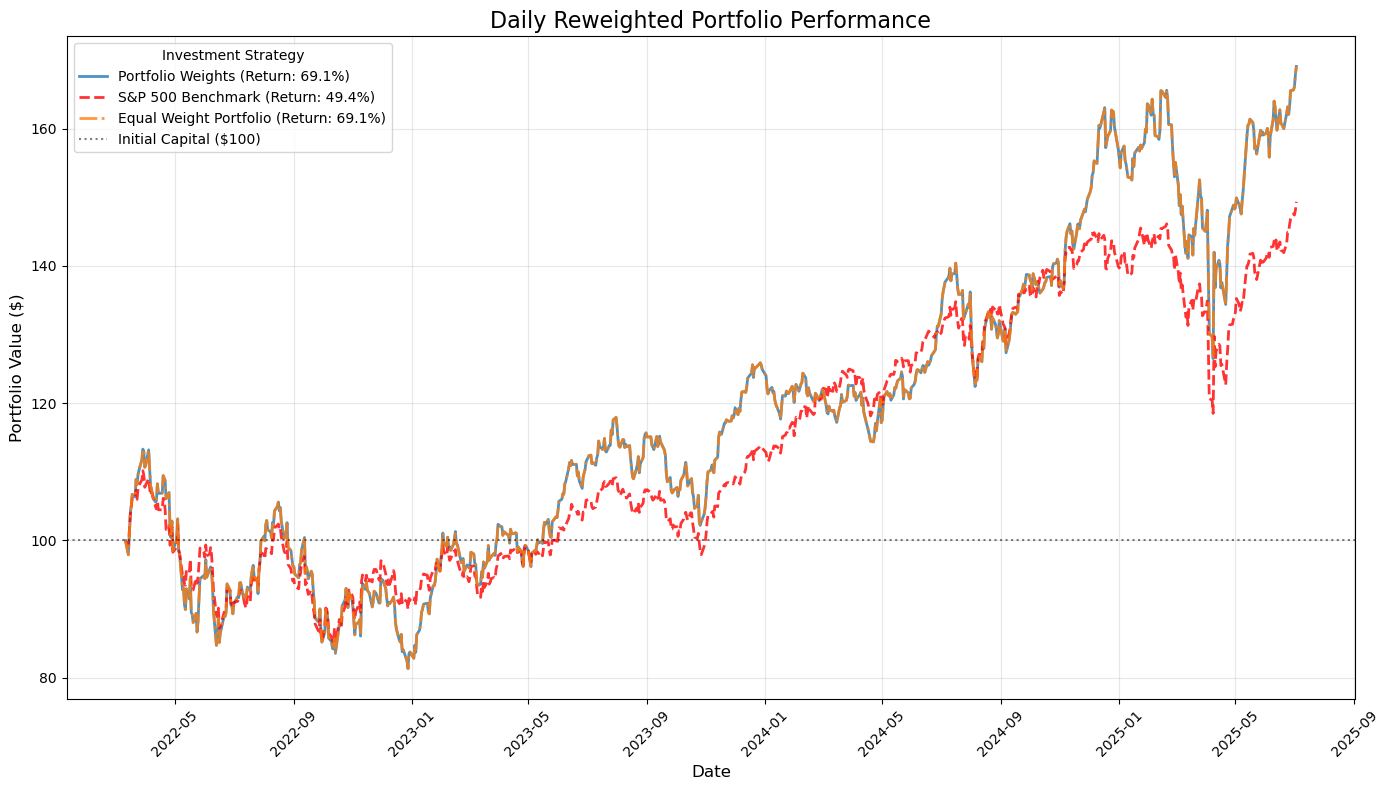

In [79]:
strategies = {}
initial_capital = 100

# Calculate S&P 500 benchmark for the test period
sp500_test = sp500[sp500['Date'] > split_date].copy().sort_values('Date')
sp500_start_price = sp500_test['Close'].iloc[0]
sp500_test['Normalized_Value'] = (sp500_test['Close'] / sp500_start_price) * initial_capital

# Implement trading strategies
plt.figure(figsize=(14, 8))

strategy_result = trade(model, test_df, initial_capital=initial_capital, target="Return_5d", trade_fees=0)

final_value = strategy_result['final_value']
total_return = (final_value / initial_capital - 1) * 100

portfolio_df = strategy_result['portfolio_df']
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], 
            label=f'Portfolio Weights (Return: {total_return:.1f}%)', 
            linewidth=2, alpha=0.8)

sp500_total_return = (sp500_test['Normalized_Value'].iloc[-1] / initial_capital - 1) * 100

plt.plot(sp500_test['Date'], sp500_test['Normalized_Value'], 
         label=f'S&P 500 Benchmark (Return: {sp500_total_return:.1f}%)', 
         color='red', linestyle='--', linewidth=2, alpha=0.8)


strategy_start_date = test_df['Date'].min()
strategy_end_date = test_df['Date'].max()

prices_test = prices.reset_index()
prices_test = prices_test[
    (prices_test['Date'] >= strategy_start_date) & 
    (prices_test['Date'] <= strategy_end_date)
].copy().sort_values('Date')

asset_cols = [c for c in prices_test.columns if c not in ['Date', 'sp500']]

equal_weights = np.ones(len(asset_cols)) / len(asset_cols)

asset_returns = prices_test[asset_cols].pct_change().fillna(0)
equal_curve = initial_capital * (1 + (asset_returns @ equal_weights)).cumprod()

# Plot + Return
equal_total_return = (equal_curve.iloc[-1] / initial_capital - 1) * 100
plt.plot(prices_test['Date'], equal_curve,
         label=f'Equal Weight Portfolio (Return: {equal_total_return:.1f}%)',
         linestyle='-.', linewidth=2, alpha=0.8)

# Add initial capital reference line
plt.axhline(y=initial_capital, color='black', linestyle=':', alpha=0.5, 
           label='Initial Capital ($100)')

plt.title('Daily Reweighted Portfolio Performance', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(title='Investment Strategy', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The first thing we do is rebalance every day. Here we gain 70% over 3 years using the same model computed above. The results are very similar to the 5 day rebalancing, perhaps unsurpising given they are both short horizons. 

The more interesting result here is that our portfolio performs exactly the same as the equally weighted portfolio. This is quite interesting as it shows that our model is not able to outperform a simple equally weighted portfolio and is likely purchasing all stocks each day with equal weights.

### Comparing to 1000 random portfolios

Strategy final value: $169.08
Random portfolios median final value: $153.57
Strategy percentile vs randoms: 81.1th


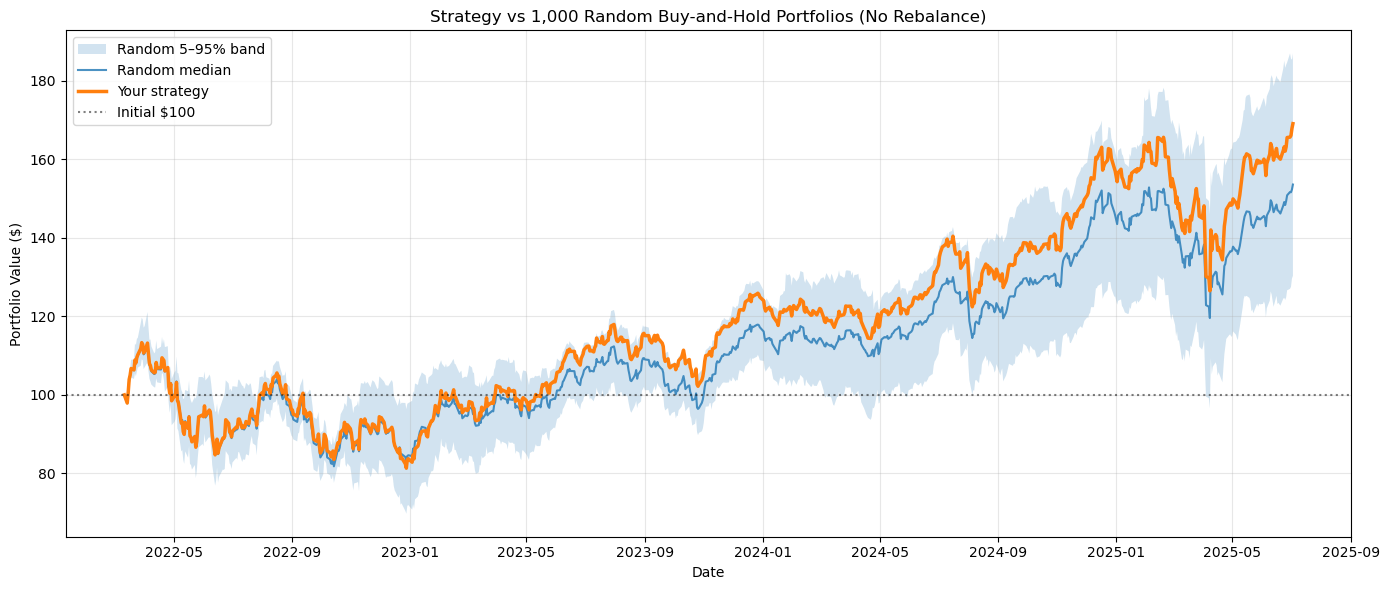

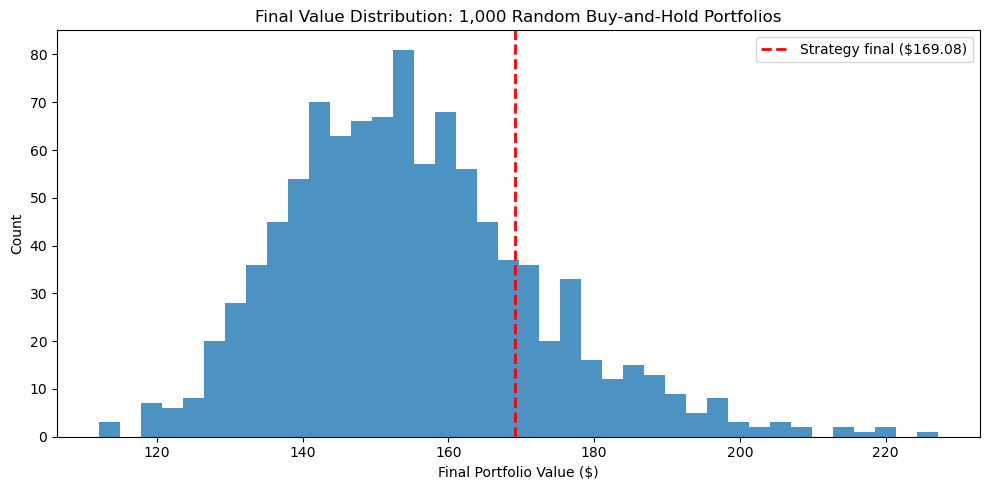

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


prices = (test_df[['Date','Ticker','Close']]
          .dropna()
          .sort_values(['Date','Ticker'])
          .pivot(index='Date', columns='Ticker', values='Close'))


start_date = portfolio_df['Date'].min()
end_date   = portfolio_df['Date'].max()
prices = prices.loc[(prices.index >= start_date) & (prices.index <= end_date)]


prices = prices.dropna(axis=1, how='any', subset=[prices.index[0]])


prices = prices.ffill()

tickers_sim = prices.columns.to_list()
n_assets = len(tickers_sim)


base = prices.iloc[0]
growth = prices.divide(base, axis=1) 


n_portfolios = 1000
rng = np.random.default_rng(42)
weights = rng.dirichlet(alpha=np.ones(n_assets), size=n_portfolios) 


rand_values = initial_capital * growth.values @ weights.T
rand_values = pd.DataFrame(rand_values, index=growth.index,
                           columns=[f'Rnd_{i}' for i in range(n_portfolios)])


rand_final = rand_values.iloc[-1]
strategy_final = float(portfolio_df.iloc[-1]['Portfolio_Value'])
strategy_percentile = (rand_final < strategy_final).mean() * 100.0

print(f"Strategy final value: ${strategy_final:,.2f}")
print(f"Random portfolios median final value: ${rand_final.median():,.2f}")
print(f"Strategy percentile vs randoms: {strategy_percentile:.1f}th")

q05 = rand_values.quantile(0.05, axis=1)
q50 = rand_values.quantile(0.50, axis=1)
q95 = rand_values.quantile(0.95, axis=1)

plt.figure(figsize=(14, 6))
plt.fill_between(q05.index, q05.values, q95.values, alpha=0.2, label='Random 5–95% band')
plt.plot(q50.index, q50.values, linewidth=1.5, alpha=0.8, label='Random median')
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], linewidth=2.5, label='Your strategy')
plt.axhline(y=initial_capital, color='black', linestyle=':', alpha=0.5, label='Initial $100')
plt.title('Strategy vs 1,000 Random Buy-and-Hold Portfolios (No Rebalance)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.hist(rand_final, bins=40, alpha=0.8)
plt.axvline(strategy_final, color='red', linestyle='--', linewidth=2,
            label=f'Strategy final (${strategy_final:,.2f})')
plt.title('Final Value Distribution: 1,000 Random Buy-and-Hold Portfolios')
plt.xlabel('Final Portfolio Value ($)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


Now, we are comparing our daily rebalanced model with one thousand portfolios with random weights. We can see that our model is in the 81 Percentile performing approximately 10 percent better than the median randomised portfolio.

In [81]:
relative_std = rand_final.std() / rand_final.mean()

print(f"Relative std (volatility): {relative_std:.2%}")

Relative std (volatility): 11.23%


### Adding Transaction Costs

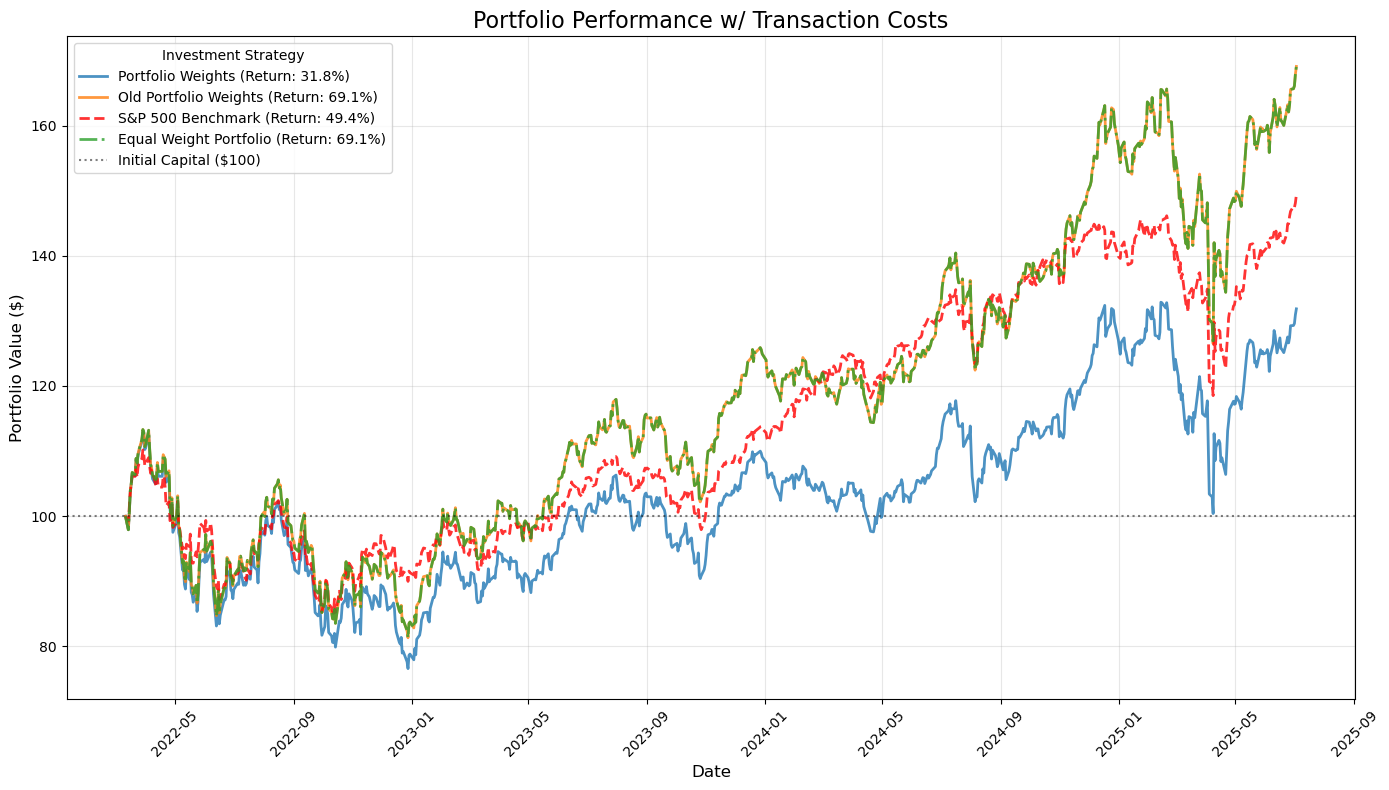

In [82]:
strategies = {}
initial_capital = 100

# Calculate S&P 500 benchmark for the test period
sp500_test = sp500[sp500['Date'] > split_date].copy().sort_values('Date')
sp500_start_price = sp500_test['Close'].iloc[0]
sp500_test['Normalized_Value'] = (sp500_test['Close'] / sp500_start_price) * initial_capital

# Implement trading strategies
plt.figure(figsize=(14, 8))

strategy_no_fees_result = trade(model, test_df, initial_capital=initial_capital, target="Return_5d", trade_fees=0) 
strategy_result = trade(model, test_df, initial_capital=initial_capital, target="Return_5d", trade_fees=0.0003)
    

final_value = strategy_result['final_value']
total_return = (final_value / initial_capital - 1) * 100

portfolio_df = strategy_result['portfolio_df']
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], 
            label=f'Portfolio Weights (Return: {total_return:.1f}%)', 
            linewidth=2, alpha=0.8)

final_value = strategy_no_fees_result['final_value']
total_return = (final_value / initial_capital - 1) * 100

portfolio_new = strategy_no_fees_result['portfolio_df']
plt.plot(portfolio_new['Date'], portfolio_new['Portfolio_Value'], 
            label=f'Old Portfolio Weights (Return: {total_return:.1f}%)', 
            linewidth=2, alpha=0.8)


sp500_total_return = (sp500_test['Normalized_Value'].iloc[-1] / initial_capital - 1) * 100

plt.plot(sp500_test['Date'], sp500_test['Normalized_Value'], 
         label=f'S&P 500 Benchmark (Return: {sp500_total_return:.1f}%)', 
         color='red', linestyle='--', linewidth=2, alpha=0.8)

strategy_start_date = test_df['Date'].min()
strategy_end_date = test_df['Date'].max()

prices_test = prices.reset_index()
prices_test = prices_test[
    (prices_test['Date'] >= strategy_start_date) & 
    (prices_test['Date'] <= strategy_end_date)
].copy().sort_values('Date')

asset_cols = [c for c in prices_test.columns if c not in ['Date', 'sp500']]

equal_weights = np.ones(len(asset_cols)) / len(asset_cols)

asset_returns = prices_test[asset_cols].pct_change().fillna(0)
equal_curve = initial_capital * (1 + (asset_returns @ equal_weights)).cumprod()

equal_total_return = (equal_curve.iloc[-1] / initial_capital - 1) * 100
plt.plot(prices_test['Date'], equal_curve,
         label=f'Equal Weight Portfolio (Return: {equal_total_return:.1f}%)',
         linestyle='-.', linewidth=2, alpha=0.8)

# Add initial capital reference line
plt.axhline(y=initial_capital, color='black', linestyle=':', alpha=0.5, 
           label='Initial Capital ($100)')

plt.title('Portfolio Performance w/ Transaction Costs', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(title='Investment Strategy', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finally, we are subtracting three basis points of trading fees for every reallocation we do. By including trading fees, we are already getting closer to reality. Non surprisingly the performance decreases very much as we are rebalancing every day. This leads to very high accumulated fees. Therefore it often makes sense to hold assets longer when having confidence on longterm returns. As the trading fees tend to decrease with high volume, intraday trading or daily rebalancing tends to be uneffective for small investors. 